<a href="https://colab.research.google.com/github/Mohit501/DCGANS/blob/main/DCGAN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Required Libraries

In [1]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
from PIL import Image

# Building Generator

In [2]:
def build_generator(inputs, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

# Building Discriminator

In [3]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

## Building a Train function

In [4]:
def train(models, x_train, params):
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    train_size = x_train.shape[0]
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
       
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
       
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
       
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)

        if (i + 1) % save_interval == 0:
            plot_images(generator,noise_input=noise_input,show=False,step=(i + 1),model_name=model_name)
   
    generator.save(model_name + ".h5")

## Building a Plot Function

In [5]:
from google.colab import files
def plot_images(generator,noise_input,show=False,step=0,model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.savefig(filename)
    plt.show()
  

## Building and Training Model

In [6]:
def build_and_train_models():
    (x_train, _), (_, _) = mnist.load_data()

    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_mnist"
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

   
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

  
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
   
    discriminator.trainable = False
    
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)

# Test Generator Function

In [7]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,noise_input=noise_input,show=True,model_name="test_outputs")

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

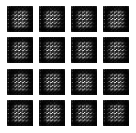

500: [discriminator loss: 0.040871, acc: 1.000000] [adversarial loss: 0.234017, acc: 1.000000]
501: [discriminator loss: 0.044128, acc: 0.992188] [adversarial loss: 0.161068, acc: 1.000000]
502: [discriminator loss: 0.049680, acc: 1.000000] [adversarial loss: 0.184312, acc: 1.000000]
503: [discriminator loss: 0.100476, acc: 0.984375] [adversarial loss: 0.073795, acc: 1.000000]
504: [discriminator loss: 0.097812, acc: 0.984375] [adversarial loss: 0.205746, acc: 1.000000]
505: [discriminator loss: 0.106752, acc: 0.976562] [adversarial loss: 0.090951, acc: 1.000000]
506: [discriminator loss: 0.108794, acc: 0.992188] [adversarial loss: 0.202183, acc: 1.000000]
507: [discriminator loss: 0.198712, acc: 0.960938] [adversarial loss: 0.027568, acc: 1.000000]
508: [discriminator loss: 0.209373, acc: 1.000000] [adversarial loss: 4.159810, acc: 0.000000]
509: [discriminator loss: 1.179821, acc: 0.554688] [adversarial loss: 0.001809, acc: 1.000000]
510: [discriminator loss: 2.166103, acc: 0.500000]

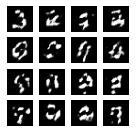

1000: [discriminator loss: 0.535655, acc: 0.750000] [adversarial loss: 0.784240, acc: 0.437500]
1001: [discriminator loss: 0.565548, acc: 0.742188] [adversarial loss: 1.457859, acc: 0.000000]
1002: [discriminator loss: 0.560240, acc: 0.703125] [adversarial loss: 0.651120, acc: 0.578125]
1003: [discriminator loss: 0.558261, acc: 0.648438] [adversarial loss: 1.981569, acc: 0.000000]
1004: [discriminator loss: 0.700219, acc: 0.617188] [adversarial loss: 0.478598, acc: 0.859375]
1005: [discriminator loss: 0.564287, acc: 0.679688] [adversarial loss: 1.339335, acc: 0.031250]
1006: [discriminator loss: 0.578035, acc: 0.718750] [adversarial loss: 0.607762, acc: 0.703125]
1007: [discriminator loss: 0.546948, acc: 0.718750] [adversarial loss: 1.344552, acc: 0.031250]
1008: [discriminator loss: 0.512487, acc: 0.726562] [adversarial loss: 0.689441, acc: 0.484375]
1009: [discriminator loss: 0.563511, acc: 0.687500] [adversarial loss: 1.214094, acc: 0.031250]
1010: [discriminator loss: 0.560148, acc

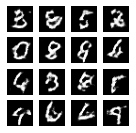

1500: [discriminator loss: 0.518661, acc: 0.734375] [adversarial loss: 1.770220, acc: 0.046875]
1501: [discriminator loss: 0.557088, acc: 0.757812] [adversarial loss: 0.928078, acc: 0.375000]
1502: [discriminator loss: 0.544360, acc: 0.734375] [adversarial loss: 1.394192, acc: 0.062500]
1503: [discriminator loss: 0.531008, acc: 0.718750] [adversarial loss: 1.022460, acc: 0.250000]
1504: [discriminator loss: 0.521387, acc: 0.687500] [adversarial loss: 1.334482, acc: 0.046875]
1505: [discriminator loss: 0.496998, acc: 0.789062] [adversarial loss: 0.799662, acc: 0.437500]
1506: [discriminator loss: 0.440419, acc: 0.851562] [adversarial loss: 1.654501, acc: 0.046875]
1507: [discriminator loss: 0.453034, acc: 0.789062] [adversarial loss: 0.911919, acc: 0.359375]
1508: [discriminator loss: 0.518884, acc: 0.750000] [adversarial loss: 1.276521, acc: 0.171875]
1509: [discriminator loss: 0.537662, acc: 0.726562] [adversarial loss: 1.109372, acc: 0.234375]
1510: [discriminator loss: 0.399870, acc

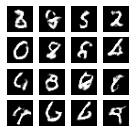

2000: [discriminator loss: 0.517341, acc: 0.734375] [adversarial loss: 1.100207, acc: 0.265625]
2001: [discriminator loss: 0.496825, acc: 0.726562] [adversarial loss: 1.139029, acc: 0.265625]
2002: [discriminator loss: 0.579032, acc: 0.710938] [adversarial loss: 1.225094, acc: 0.203125]
2003: [discriminator loss: 0.462355, acc: 0.804688] [adversarial loss: 1.469254, acc: 0.140625]
2004: [discriminator loss: 0.490195, acc: 0.750000] [adversarial loss: 1.136809, acc: 0.281250]
2005: [discriminator loss: 0.526730, acc: 0.734375] [adversarial loss: 1.508381, acc: 0.171875]
2006: [discriminator loss: 0.527727, acc: 0.773438] [adversarial loss: 0.782292, acc: 0.453125]
2007: [discriminator loss: 0.575257, acc: 0.679688] [adversarial loss: 1.565937, acc: 0.078125]
2008: [discriminator loss: 0.556030, acc: 0.765625] [adversarial loss: 1.142414, acc: 0.265625]
2009: [discriminator loss: 0.491962, acc: 0.757812] [adversarial loss: 1.454797, acc: 0.187500]
2010: [discriminator loss: 0.532159, acc

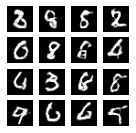

2500: [discriminator loss: 0.505962, acc: 0.773438] [adversarial loss: 1.148945, acc: 0.218750]
2501: [discriminator loss: 0.445419, acc: 0.796875] [adversarial loss: 1.860331, acc: 0.062500]
2502: [discriminator loss: 0.630643, acc: 0.710938] [adversarial loss: 0.722170, acc: 0.578125]
2503: [discriminator loss: 0.526591, acc: 0.726562] [adversarial loss: 1.864158, acc: 0.156250]
2504: [discriminator loss: 0.570818, acc: 0.734375] [adversarial loss: 1.055687, acc: 0.406250]
2505: [discriminator loss: 0.489041, acc: 0.734375] [adversarial loss: 1.532482, acc: 0.156250]
2506: [discriminator loss: 0.478133, acc: 0.789062] [adversarial loss: 1.075226, acc: 0.234375]
2507: [discriminator loss: 0.596623, acc: 0.648438] [adversarial loss: 1.450693, acc: 0.187500]
2508: [discriminator loss: 0.634230, acc: 0.671875] [adversarial loss: 1.466471, acc: 0.125000]
2509: [discriminator loss: 0.596348, acc: 0.718750] [adversarial loss: 0.996387, acc: 0.328125]
2510: [discriminator loss: 0.478042, acc

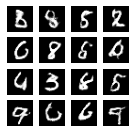

3000: [discriminator loss: 0.559391, acc: 0.734375] [adversarial loss: 1.842534, acc: 0.078125]
3001: [discriminator loss: 0.546660, acc: 0.695312] [adversarial loss: 0.916815, acc: 0.375000]
3002: [discriminator loss: 0.512283, acc: 0.750000] [adversarial loss: 1.694921, acc: 0.140625]
3003: [discriminator loss: 0.499206, acc: 0.726562] [adversarial loss: 1.037279, acc: 0.296875]
3004: [discriminator loss: 0.449615, acc: 0.828125] [adversarial loss: 1.188867, acc: 0.343750]
3005: [discriminator loss: 0.506560, acc: 0.671875] [adversarial loss: 1.293494, acc: 0.234375]
3006: [discriminator loss: 0.487927, acc: 0.742188] [adversarial loss: 1.313470, acc: 0.250000]
3007: [discriminator loss: 0.536252, acc: 0.726562] [adversarial loss: 1.137336, acc: 0.343750]
3008: [discriminator loss: 0.490334, acc: 0.757812] [adversarial loss: 1.376668, acc: 0.187500]
3009: [discriminator loss: 0.521946, acc: 0.765625] [adversarial loss: 1.275487, acc: 0.281250]
3010: [discriminator loss: 0.463169, acc

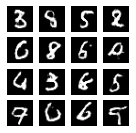

3500: [discriminator loss: 0.477431, acc: 0.757812] [adversarial loss: 1.671745, acc: 0.109375]
3501: [discriminator loss: 0.478957, acc: 0.804688] [adversarial loss: 0.850710, acc: 0.453125]
3502: [discriminator loss: 0.598445, acc: 0.726562] [adversarial loss: 1.614169, acc: 0.109375]
3503: [discriminator loss: 0.474108, acc: 0.734375] [adversarial loss: 1.165342, acc: 0.234375]
3504: [discriminator loss: 0.486577, acc: 0.781250] [adversarial loss: 1.936247, acc: 0.078125]
3505: [discriminator loss: 0.461465, acc: 0.773438] [adversarial loss: 0.968427, acc: 0.468750]
3506: [discriminator loss: 0.544319, acc: 0.695312] [adversarial loss: 1.718130, acc: 0.140625]
3507: [discriminator loss: 0.539830, acc: 0.726562] [adversarial loss: 1.038719, acc: 0.281250]
3508: [discriminator loss: 0.473704, acc: 0.718750] [adversarial loss: 1.820471, acc: 0.125000]
3509: [discriminator loss: 0.581566, acc: 0.695312] [adversarial loss: 1.243672, acc: 0.203125]
3510: [discriminator loss: 0.579138, acc

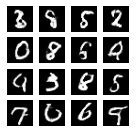

4000: [discriminator loss: 0.539893, acc: 0.734375] [adversarial loss: 1.685095, acc: 0.062500]
4001: [discriminator loss: 0.557640, acc: 0.687500] [adversarial loss: 1.180429, acc: 0.281250]
4002: [discriminator loss: 0.525535, acc: 0.718750] [adversarial loss: 1.656726, acc: 0.109375]
4003: [discriminator loss: 0.520943, acc: 0.742188] [adversarial loss: 1.117556, acc: 0.218750]
4004: [discriminator loss: 0.506398, acc: 0.789062] [adversarial loss: 1.730057, acc: 0.078125]
4005: [discriminator loss: 0.441140, acc: 0.781250] [adversarial loss: 1.216775, acc: 0.265625]
4006: [discriminator loss: 0.550578, acc: 0.695312] [adversarial loss: 1.551794, acc: 0.109375]
4007: [discriminator loss: 0.508143, acc: 0.765625] [adversarial loss: 1.022476, acc: 0.328125]
4008: [discriminator loss: 0.525355, acc: 0.742188] [adversarial loss: 1.169501, acc: 0.265625]
4009: [discriminator loss: 0.564884, acc: 0.679688] [adversarial loss: 1.521624, acc: 0.171875]
4010: [discriminator loss: 0.539422, acc

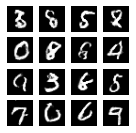

4500: [discriminator loss: 0.515578, acc: 0.718750] [adversarial loss: 1.132770, acc: 0.218750]
4501: [discriminator loss: 0.498298, acc: 0.750000] [adversarial loss: 1.350894, acc: 0.140625]
4502: [discriminator loss: 0.526767, acc: 0.750000] [adversarial loss: 1.338950, acc: 0.218750]
4503: [discriminator loss: 0.520423, acc: 0.687500] [adversarial loss: 1.272357, acc: 0.187500]
4504: [discriminator loss: 0.531458, acc: 0.734375] [adversarial loss: 1.521061, acc: 0.156250]
4505: [discriminator loss: 0.525266, acc: 0.750000] [adversarial loss: 0.885527, acc: 0.437500]
4506: [discriminator loss: 0.519307, acc: 0.750000] [adversarial loss: 1.649908, acc: 0.171875]
4507: [discriminator loss: 0.555533, acc: 0.710938] [adversarial loss: 0.587403, acc: 0.718750]
4508: [discriminator loss: 0.572894, acc: 0.632812] [adversarial loss: 1.720963, acc: 0.093750]
4509: [discriminator loss: 0.560573, acc: 0.695312] [adversarial loss: 0.903724, acc: 0.375000]
4510: [discriminator loss: 0.529194, acc

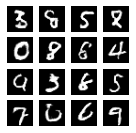

5000: [discriminator loss: 0.559924, acc: 0.750000] [adversarial loss: 1.325342, acc: 0.203125]
5001: [discriminator loss: 0.515321, acc: 0.742188] [adversarial loss: 1.200423, acc: 0.203125]
5002: [discriminator loss: 0.504554, acc: 0.742188] [adversarial loss: 1.289327, acc: 0.218750]
5003: [discriminator loss: 0.528564, acc: 0.750000] [adversarial loss: 1.228422, acc: 0.203125]
5004: [discriminator loss: 0.590740, acc: 0.718750] [adversarial loss: 1.412500, acc: 0.203125]
5005: [discriminator loss: 0.600502, acc: 0.671875] [adversarial loss: 0.970194, acc: 0.312500]
5006: [discriminator loss: 0.541993, acc: 0.710938] [adversarial loss: 1.458316, acc: 0.218750]
5007: [discriminator loss: 0.474023, acc: 0.789062] [adversarial loss: 0.990999, acc: 0.421875]
5008: [discriminator loss: 0.518879, acc: 0.765625] [adversarial loss: 1.079661, acc: 0.312500]
5009: [discriminator loss: 0.477538, acc: 0.757812] [adversarial loss: 1.431178, acc: 0.218750]
5010: [discriminator loss: 0.558612, acc

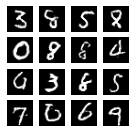

5500: [discriminator loss: 0.580925, acc: 0.703125] [adversarial loss: 1.064521, acc: 0.265625]
5501: [discriminator loss: 0.516600, acc: 0.742188] [adversarial loss: 1.266823, acc: 0.203125]
5502: [discriminator loss: 0.570943, acc: 0.679688] [adversarial loss: 1.003775, acc: 0.390625]
5503: [discriminator loss: 0.558196, acc: 0.718750] [adversarial loss: 1.397548, acc: 0.140625]
5504: [discriminator loss: 0.587921, acc: 0.687500] [adversarial loss: 1.119193, acc: 0.265625]
5505: [discriminator loss: 0.549412, acc: 0.710938] [adversarial loss: 1.313866, acc: 0.109375]
5506: [discriminator loss: 0.468386, acc: 0.796875] [adversarial loss: 1.055620, acc: 0.281250]
5507: [discriminator loss: 0.547424, acc: 0.750000] [adversarial loss: 1.355542, acc: 0.187500]
5508: [discriminator loss: 0.531264, acc: 0.703125] [adversarial loss: 0.992775, acc: 0.343750]
5509: [discriminator loss: 0.599754, acc: 0.656250] [adversarial loss: 1.379679, acc: 0.109375]
5510: [discriminator loss: 0.595963, acc

6000: [discriminator loss: 0.631648, acc: 0.695312] [adversarial loss: 1.518581, acc: 0.125000]
6001: [discriminator loss: 0.586983, acc: 0.687500] [adversarial loss: 0.798972, acc: 0.359375]
6002: [discriminator loss: 0.624388, acc: 0.664062] [adversarial loss: 1.972182, acc: 0.046875]
6003: [discriminator loss: 0.619800, acc: 0.648438] [adversarial loss: 0.949871, acc: 0.421875]
6004: [discriminator loss: 0.601216, acc: 0.718750] [adversarial loss: 1.507961, acc: 0.062500]
6005: [discriminator loss: 0.550140, acc: 0.679688] [adversarial loss: 1.025636, acc: 0.328125]
6006: [discriminator loss: 0.486593, acc: 0.742188] [adversarial loss: 1.122236, acc: 0.250000]
6007: [discriminator loss: 0.565540, acc: 0.671875] [adversarial loss: 1.201348, acc: 0.171875]
6008: [discriminator loss: 0.513147, acc: 0.781250] [adversarial loss: 0.903464, acc: 0.453125]
6009: [discriminator loss: 0.565299, acc: 0.726562] [adversarial loss: 1.497352, acc: 0.140625]
6010: [discriminator loss: 0.496944, acc

6500: [discriminator loss: 0.573098, acc: 0.703125] [adversarial loss: 1.542718, acc: 0.015625]
6501: [discriminator loss: 0.584773, acc: 0.687500] [adversarial loss: 1.025312, acc: 0.281250]
6502: [discriminator loss: 0.523493, acc: 0.742188] [adversarial loss: 1.251259, acc: 0.234375]
6503: [discriminator loss: 0.526229, acc: 0.742188] [adversarial loss: 1.363784, acc: 0.171875]
6504: [discriminator loss: 0.572773, acc: 0.703125] [adversarial loss: 1.027322, acc: 0.281250]
6505: [discriminator loss: 0.578307, acc: 0.703125] [adversarial loss: 1.213010, acc: 0.296875]
6506: [discriminator loss: 0.584819, acc: 0.679688] [adversarial loss: 0.932637, acc: 0.390625]
6507: [discriminator loss: 0.588174, acc: 0.710938] [adversarial loss: 1.493279, acc: 0.093750]
6508: [discriminator loss: 0.551764, acc: 0.710938] [adversarial loss: 0.965625, acc: 0.359375]
6509: [discriminator loss: 0.531691, acc: 0.742188] [adversarial loss: 1.261984, acc: 0.187500]
6510: [discriminator loss: 0.498097, acc

7000: [discriminator loss: 0.445177, acc: 0.812500] [adversarial loss: 1.485270, acc: 0.078125]
7001: [discriminator loss: 0.552170, acc: 0.695312] [adversarial loss: 0.792615, acc: 0.546875]
7002: [discriminator loss: 0.602861, acc: 0.679688] [adversarial loss: 1.487616, acc: 0.156250]
7003: [discriminator loss: 0.589589, acc: 0.695312] [adversarial loss: 0.779612, acc: 0.484375]
7004: [discriminator loss: 0.575279, acc: 0.703125] [adversarial loss: 1.588942, acc: 0.109375]
7005: [discriminator loss: 0.608096, acc: 0.648438] [adversarial loss: 0.886343, acc: 0.500000]
7006: [discriminator loss: 0.527725, acc: 0.726562] [adversarial loss: 1.456465, acc: 0.062500]
7007: [discriminator loss: 0.539502, acc: 0.687500] [adversarial loss: 1.038374, acc: 0.343750]
7008: [discriminator loss: 0.581027, acc: 0.664062] [adversarial loss: 1.247344, acc: 0.218750]
7009: [discriminator loss: 0.505479, acc: 0.773438] [adversarial loss: 1.033836, acc: 0.375000]
7010: [discriminator loss: 0.556326, acc

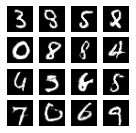

7500: [discriminator loss: 0.505549, acc: 0.750000] [adversarial loss: 1.122214, acc: 0.390625]
7501: [discriminator loss: 0.490903, acc: 0.742188] [adversarial loss: 1.426949, acc: 0.125000]
7502: [discriminator loss: 0.635323, acc: 0.625000] [adversarial loss: 0.855861, acc: 0.453125]
7503: [discriminator loss: 0.634645, acc: 0.625000] [adversarial loss: 1.433614, acc: 0.125000]
7504: [discriminator loss: 0.625103, acc: 0.679688] [adversarial loss: 0.818510, acc: 0.437500]
7505: [discriminator loss: 0.549961, acc: 0.718750] [adversarial loss: 1.140425, acc: 0.281250]
7506: [discriminator loss: 0.541420, acc: 0.750000] [adversarial loss: 1.100493, acc: 0.281250]
7507: [discriminator loss: 0.537328, acc: 0.703125] [adversarial loss: 0.978781, acc: 0.312500]
7508: [discriminator loss: 0.510397, acc: 0.750000] [adversarial loss: 1.066857, acc: 0.281250]
7509: [discriminator loss: 0.486511, acc: 0.781250] [adversarial loss: 1.114345, acc: 0.328125]
7510: [discriminator loss: 0.436431, acc

8000: [discriminator loss: 0.493140, acc: 0.773438] [adversarial loss: 1.107597, acc: 0.250000]
8001: [discriminator loss: 0.529159, acc: 0.726562] [adversarial loss: 1.271487, acc: 0.234375]
8002: [discriminator loss: 0.562430, acc: 0.687500] [adversarial loss: 0.832162, acc: 0.484375]
8003: [discriminator loss: 0.585024, acc: 0.687500] [adversarial loss: 1.406792, acc: 0.203125]
8004: [discriminator loss: 0.603173, acc: 0.679688] [adversarial loss: 0.848655, acc: 0.484375]
8005: [discriminator loss: 0.567512, acc: 0.710938] [adversarial loss: 1.364677, acc: 0.125000]
8006: [discriminator loss: 0.612661, acc: 0.664062] [adversarial loss: 0.992549, acc: 0.359375]
8007: [discriminator loss: 0.576177, acc: 0.726562] [adversarial loss: 1.386647, acc: 0.125000]
8008: [discriminator loss: 0.556658, acc: 0.710938] [adversarial loss: 0.979135, acc: 0.328125]
8009: [discriminator loss: 0.502892, acc: 0.765625] [adversarial loss: 1.293352, acc: 0.187500]
8010: [discriminator loss: 0.502484, acc

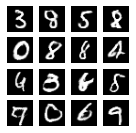

8500: [discriminator loss: 0.646136, acc: 0.625000] [adversarial loss: 1.956269, acc: 0.093750]
8501: [discriminator loss: 0.666840, acc: 0.648438] [adversarial loss: 0.776001, acc: 0.515625]
8502: [discriminator loss: 0.530915, acc: 0.773438] [adversarial loss: 1.357629, acc: 0.156250]
8503: [discriminator loss: 0.541782, acc: 0.742188] [adversarial loss: 0.867553, acc: 0.500000]
8504: [discriminator loss: 0.589545, acc: 0.671875] [adversarial loss: 1.171908, acc: 0.281250]
8505: [discriminator loss: 0.540139, acc: 0.710938] [adversarial loss: 1.208829, acc: 0.218750]
8506: [discriminator loss: 0.523661, acc: 0.789062] [adversarial loss: 1.280992, acc: 0.203125]
8507: [discriminator loss: 0.553554, acc: 0.742188] [adversarial loss: 1.029169, acc: 0.296875]
8508: [discriminator loss: 0.594791, acc: 0.679688] [adversarial loss: 1.204455, acc: 0.218750]
8509: [discriminator loss: 0.555990, acc: 0.671875] [adversarial loss: 1.222609, acc: 0.296875]
8510: [discriminator loss: 0.507013, acc

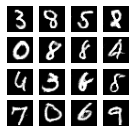

9000: [discriminator loss: 0.472751, acc: 0.773438] [adversarial loss: 1.413287, acc: 0.156250]
9001: [discriminator loss: 0.477592, acc: 0.750000] [adversarial loss: 1.072402, acc: 0.343750]
9002: [discriminator loss: 0.455077, acc: 0.820312] [adversarial loss: 1.254611, acc: 0.234375]
9003: [discriminator loss: 0.556116, acc: 0.695312] [adversarial loss: 1.055419, acc: 0.312500]
9004: [discriminator loss: 0.587214, acc: 0.664062] [adversarial loss: 1.392323, acc: 0.140625]
9005: [discriminator loss: 0.551583, acc: 0.757812] [adversarial loss: 1.156321, acc: 0.265625]
9006: [discriminator loss: 0.585443, acc: 0.726562] [adversarial loss: 1.031708, acc: 0.359375]
9007: [discriminator loss: 0.554973, acc: 0.679688] [adversarial loss: 1.100962, acc: 0.265625]
9008: [discriminator loss: 0.566097, acc: 0.718750] [adversarial loss: 1.313173, acc: 0.125000]
9009: [discriminator loss: 0.579190, acc: 0.718750] [adversarial loss: 1.077349, acc: 0.203125]
9010: [discriminator loss: 0.508592, acc

9500: [discriminator loss: 0.502420, acc: 0.742188] [adversarial loss: 1.275382, acc: 0.187500]
9501: [discriminator loss: 0.542939, acc: 0.703125] [adversarial loss: 1.014555, acc: 0.281250]
9502: [discriminator loss: 0.501460, acc: 0.773438] [adversarial loss: 1.300425, acc: 0.171875]
9503: [discriminator loss: 0.525727, acc: 0.765625] [adversarial loss: 1.188956, acc: 0.328125]
9504: [discriminator loss: 0.505928, acc: 0.765625] [adversarial loss: 1.095413, acc: 0.234375]
9505: [discriminator loss: 0.547003, acc: 0.687500] [adversarial loss: 1.420804, acc: 0.171875]
9506: [discriminator loss: 0.510709, acc: 0.734375] [adversarial loss: 1.150339, acc: 0.250000]
9507: [discriminator loss: 0.583614, acc: 0.726562] [adversarial loss: 1.136331, acc: 0.265625]
9508: [discriminator loss: 0.584688, acc: 0.703125] [adversarial loss: 1.062995, acc: 0.296875]
9509: [discriminator loss: 0.529546, acc: 0.726562] [adversarial loss: 1.241605, acc: 0.218750]
9510: [discriminator loss: 0.578092, acc

10000: [discriminator loss: 0.618511, acc: 0.664062] [adversarial loss: 1.042284, acc: 0.296875]
10001: [discriminator loss: 0.508893, acc: 0.757812] [adversarial loss: 1.355739, acc: 0.171875]
10002: [discriminator loss: 0.553228, acc: 0.750000] [adversarial loss: 0.880801, acc: 0.453125]
10003: [discriminator loss: 0.500140, acc: 0.757812] [adversarial loss: 1.218076, acc: 0.281250]
10004: [discriminator loss: 0.524354, acc: 0.742188] [adversarial loss: 1.198793, acc: 0.234375]
10005: [discriminator loss: 0.519809, acc: 0.750000] [adversarial loss: 1.212379, acc: 0.218750]
10006: [discriminator loss: 0.494929, acc: 0.726562] [adversarial loss: 1.080767, acc: 0.359375]
10007: [discriminator loss: 0.597063, acc: 0.671875] [adversarial loss: 1.616619, acc: 0.140625]
10008: [discriminator loss: 0.605603, acc: 0.679688] [adversarial loss: 1.115144, acc: 0.296875]
10009: [discriminator loss: 0.605501, acc: 0.664062] [adversarial loss: 1.529847, acc: 0.015625]
10010: [discriminator loss: 0.

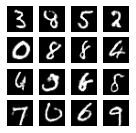

10500: [discriminator loss: 0.527520, acc: 0.765625] [adversarial loss: 1.408645, acc: 0.062500]
10501: [discriminator loss: 0.576335, acc: 0.664062] [adversarial loss: 1.127928, acc: 0.281250]
10502: [discriminator loss: 0.623928, acc: 0.656250] [adversarial loss: 1.296588, acc: 0.281250]
10503: [discriminator loss: 0.591959, acc: 0.734375] [adversarial loss: 1.163954, acc: 0.234375]
10504: [discriminator loss: 0.552617, acc: 0.742188] [adversarial loss: 1.129512, acc: 0.250000]
10505: [discriminator loss: 0.572381, acc: 0.765625] [adversarial loss: 1.057583, acc: 0.250000]
10506: [discriminator loss: 0.559699, acc: 0.679688] [adversarial loss: 1.236826, acc: 0.234375]
10507: [discriminator loss: 0.550595, acc: 0.687500] [adversarial loss: 1.061472, acc: 0.296875]
10508: [discriminator loss: 0.547514, acc: 0.734375] [adversarial loss: 1.391737, acc: 0.171875]
10509: [discriminator loss: 0.575739, acc: 0.718750] [adversarial loss: 0.599250, acc: 0.687500]
10510: [discriminator loss: 0.

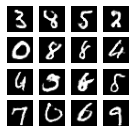

11000: [discriminator loss: 0.557371, acc: 0.695312] [adversarial loss: 1.349362, acc: 0.281250]
11001: [discriminator loss: 0.530127, acc: 0.718750] [adversarial loss: 1.329865, acc: 0.218750]
11002: [discriminator loss: 0.539160, acc: 0.742188] [adversarial loss: 1.443204, acc: 0.171875]
11003: [discriminator loss: 0.484567, acc: 0.796875] [adversarial loss: 1.122537, acc: 0.281250]
11004: [discriminator loss: 0.551502, acc: 0.671875] [adversarial loss: 1.280856, acc: 0.250000]
11005: [discriminator loss: 0.462344, acc: 0.773438] [adversarial loss: 1.013699, acc: 0.375000]
11006: [discriminator loss: 0.521127, acc: 0.710938] [adversarial loss: 1.478668, acc: 0.156250]
11007: [discriminator loss: 0.548269, acc: 0.710938] [adversarial loss: 1.027759, acc: 0.312500]
11008: [discriminator loss: 0.604026, acc: 0.664062] [adversarial loss: 1.317027, acc: 0.218750]
11009: [discriminator loss: 0.496571, acc: 0.726562] [adversarial loss: 1.108674, acc: 0.234375]
11010: [discriminator loss: 0.

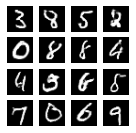

11500: [discriminator loss: 0.516832, acc: 0.750000] [adversarial loss: 1.207804, acc: 0.218750]
11501: [discriminator loss: 0.605734, acc: 0.726562] [adversarial loss: 0.992751, acc: 0.375000]
11502: [discriminator loss: 0.488647, acc: 0.765625] [adversarial loss: 1.261179, acc: 0.171875]
11503: [discriminator loss: 0.498670, acc: 0.765625] [adversarial loss: 1.014263, acc: 0.390625]
11504: [discriminator loss: 0.587109, acc: 0.695312] [adversarial loss: 1.091363, acc: 0.406250]
11505: [discriminator loss: 0.595598, acc: 0.656250] [adversarial loss: 1.546279, acc: 0.078125]
11506: [discriminator loss: 0.591612, acc: 0.656250] [adversarial loss: 0.729759, acc: 0.578125]
11507: [discriminator loss: 0.572069, acc: 0.687500] [adversarial loss: 1.825202, acc: 0.078125]
11508: [discriminator loss: 0.633881, acc: 0.640625] [adversarial loss: 1.021445, acc: 0.390625]
11509: [discriminator loss: 0.552801, acc: 0.695312] [adversarial loss: 1.271308, acc: 0.218750]
11510: [discriminator loss: 0.

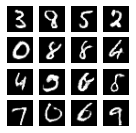

12000: [discriminator loss: 0.521424, acc: 0.734375] [adversarial loss: 0.924353, acc: 0.406250]
12001: [discriminator loss: 0.535030, acc: 0.734375] [adversarial loss: 1.438306, acc: 0.171875]
12002: [discriminator loss: 0.527866, acc: 0.781250] [adversarial loss: 1.095147, acc: 0.312500]
12003: [discriminator loss: 0.472864, acc: 0.757812] [adversarial loss: 1.217357, acc: 0.218750]
12004: [discriminator loss: 0.553654, acc: 0.695312] [adversarial loss: 1.106829, acc: 0.265625]
12005: [discriminator loss: 0.491532, acc: 0.773438] [adversarial loss: 1.341684, acc: 0.218750]
12006: [discriminator loss: 0.562443, acc: 0.718750] [adversarial loss: 1.299315, acc: 0.265625]
12007: [discriminator loss: 0.504482, acc: 0.710938] [adversarial loss: 1.135226, acc: 0.250000]
12008: [discriminator loss: 0.533196, acc: 0.718750] [adversarial loss: 0.877131, acc: 0.515625]
12009: [discriminator loss: 0.568404, acc: 0.687500] [adversarial loss: 1.626832, acc: 0.125000]
12010: [discriminator loss: 0.

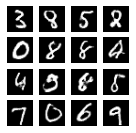

12500: [discriminator loss: 0.514294, acc: 0.734375] [adversarial loss: 1.319702, acc: 0.140625]
12501: [discriminator loss: 0.476888, acc: 0.812500] [adversarial loss: 1.394922, acc: 0.218750]
12502: [discriminator loss: 0.536561, acc: 0.718750] [adversarial loss: 0.942737, acc: 0.390625]
12503: [discriminator loss: 0.577933, acc: 0.718750] [adversarial loss: 1.143246, acc: 0.265625]
12504: [discriminator loss: 0.570203, acc: 0.679688] [adversarial loss: 1.031096, acc: 0.296875]
12505: [discriminator loss: 0.542099, acc: 0.671875] [adversarial loss: 1.388547, acc: 0.109375]
12506: [discriminator loss: 0.561588, acc: 0.703125] [adversarial loss: 1.134997, acc: 0.312500]
12507: [discriminator loss: 0.600375, acc: 0.617188] [adversarial loss: 1.238902, acc: 0.328125]
12508: [discriminator loss: 0.571357, acc: 0.664062] [adversarial loss: 1.265731, acc: 0.250000]
12509: [discriminator loss: 0.539509, acc: 0.718750] [adversarial loss: 1.215494, acc: 0.328125]
12510: [discriminator loss: 0.

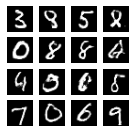

13000: [discriminator loss: 0.663799, acc: 0.656250] [adversarial loss: 1.380104, acc: 0.156250]
13001: [discriminator loss: 0.566475, acc: 0.679688] [adversarial loss: 1.120682, acc: 0.265625]
13002: [discriminator loss: 0.539038, acc: 0.765625] [adversarial loss: 1.277897, acc: 0.203125]
13003: [discriminator loss: 0.538309, acc: 0.718750] [adversarial loss: 1.085722, acc: 0.312500]
13004: [discriminator loss: 0.545491, acc: 0.726562] [adversarial loss: 1.350144, acc: 0.156250]
13005: [discriminator loss: 0.503199, acc: 0.765625] [adversarial loss: 1.103954, acc: 0.328125]
13006: [discriminator loss: 0.589324, acc: 0.679688] [adversarial loss: 1.289970, acc: 0.171875]
13007: [discriminator loss: 0.541764, acc: 0.671875] [adversarial loss: 1.157132, acc: 0.312500]
13008: [discriminator loss: 0.573892, acc: 0.671875] [adversarial loss: 1.164971, acc: 0.250000]
13009: [discriminator loss: 0.493574, acc: 0.757812] [adversarial loss: 1.197271, acc: 0.296875]
13010: [discriminator loss: 0.

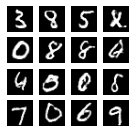

13500: [discriminator loss: 0.524998, acc: 0.757812] [adversarial loss: 1.276080, acc: 0.187500]
13501: [discriminator loss: 0.487354, acc: 0.757812] [adversarial loss: 1.180950, acc: 0.234375]
13502: [discriminator loss: 0.476072, acc: 0.734375] [adversarial loss: 1.144085, acc: 0.296875]
13503: [discriminator loss: 0.542229, acc: 0.703125] [adversarial loss: 1.226086, acc: 0.234375]
13504: [discriminator loss: 0.566815, acc: 0.742188] [adversarial loss: 1.096601, acc: 0.296875]
13505: [discriminator loss: 0.516719, acc: 0.734375] [adversarial loss: 1.249238, acc: 0.296875]
13506: [discriminator loss: 0.606139, acc: 0.664062] [adversarial loss: 1.159473, acc: 0.218750]
13507: [discriminator loss: 0.495467, acc: 0.750000] [adversarial loss: 1.190591, acc: 0.203125]
13508: [discriminator loss: 0.556447, acc: 0.710938] [adversarial loss: 0.906631, acc: 0.453125]
13509: [discriminator loss: 0.603534, acc: 0.671875] [adversarial loss: 1.575509, acc: 0.093750]
13510: [discriminator loss: 0.

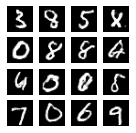

14000: [discriminator loss: 0.519549, acc: 0.750000] [adversarial loss: 1.587530, acc: 0.125000]
14001: [discriminator loss: 0.548523, acc: 0.695312] [adversarial loss: 0.974667, acc: 0.468750]
14002: [discriminator loss: 0.619773, acc: 0.656250] [adversarial loss: 1.255702, acc: 0.156250]
14003: [discriminator loss: 0.577888, acc: 0.710938] [adversarial loss: 0.941601, acc: 0.359375]
14004: [discriminator loss: 0.481348, acc: 0.773438] [adversarial loss: 1.086582, acc: 0.312500]
14005: [discriminator loss: 0.584706, acc: 0.687500] [adversarial loss: 1.560942, acc: 0.140625]
14006: [discriminator loss: 0.559408, acc: 0.687500] [adversarial loss: 1.075033, acc: 0.343750]
14007: [discriminator loss: 0.509411, acc: 0.726562] [adversarial loss: 1.165397, acc: 0.328125]
14008: [discriminator loss: 0.549245, acc: 0.648438] [adversarial loss: 1.142914, acc: 0.250000]
14009: [discriminator loss: 0.524076, acc: 0.750000] [adversarial loss: 1.019673, acc: 0.437500]
14010: [discriminator loss: 0.

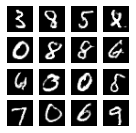

14500: [discriminator loss: 0.500398, acc: 0.773438] [adversarial loss: 1.211901, acc: 0.250000]
14501: [discriminator loss: 0.444624, acc: 0.804688] [adversarial loss: 1.062786, acc: 0.343750]
14502: [discriminator loss: 0.623697, acc: 0.648438] [adversarial loss: 1.154388, acc: 0.296875]
14503: [discriminator loss: 0.539304, acc: 0.695312] [adversarial loss: 1.113054, acc: 0.328125]
14504: [discriminator loss: 0.462374, acc: 0.750000] [adversarial loss: 0.984938, acc: 0.343750]
14505: [discriminator loss: 0.555036, acc: 0.695312] [adversarial loss: 1.086036, acc: 0.328125]
14506: [discriminator loss: 0.594951, acc: 0.601562] [adversarial loss: 1.461439, acc: 0.203125]
14507: [discriminator loss: 0.542461, acc: 0.703125] [adversarial loss: 1.072681, acc: 0.328125]
14508: [discriminator loss: 0.500458, acc: 0.757812] [adversarial loss: 1.453306, acc: 0.218750]
14509: [discriminator loss: 0.527621, acc: 0.703125] [adversarial loss: 1.023308, acc: 0.281250]
14510: [discriminator loss: 0.

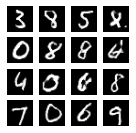

15000: [discriminator loss: 0.554164, acc: 0.710938] [adversarial loss: 0.960742, acc: 0.375000]
15001: [discriminator loss: 0.506759, acc: 0.742188] [adversarial loss: 1.674025, acc: 0.109375]
15002: [discriminator loss: 0.618608, acc: 0.671875] [adversarial loss: 1.145235, acc: 0.296875]
15003: [discriminator loss: 0.575294, acc: 0.648438] [adversarial loss: 1.154909, acc: 0.265625]
15004: [discriminator loss: 0.531181, acc: 0.710938] [adversarial loss: 1.184552, acc: 0.281250]
15005: [discriminator loss: 0.517683, acc: 0.750000] [adversarial loss: 1.541799, acc: 0.078125]
15006: [discriminator loss: 0.519387, acc: 0.734375] [adversarial loss: 1.094700, acc: 0.281250]
15007: [discriminator loss: 0.548171, acc: 0.687500] [adversarial loss: 1.476081, acc: 0.156250]
15008: [discriminator loss: 0.549089, acc: 0.718750] [adversarial loss: 0.913550, acc: 0.406250]
15009: [discriminator loss: 0.552281, acc: 0.710938] [adversarial loss: 1.880283, acc: 0.109375]
15010: [discriminator loss: 0.

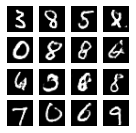

15500: [discriminator loss: 0.581305, acc: 0.656250] [adversarial loss: 0.854293, acc: 0.453125]
15501: [discriminator loss: 0.543473, acc: 0.734375] [adversarial loss: 1.412333, acc: 0.156250]
15502: [discriminator loss: 0.529822, acc: 0.710938] [adversarial loss: 0.845115, acc: 0.453125]
15503: [discriminator loss: 0.527202, acc: 0.710938] [adversarial loss: 1.227886, acc: 0.265625]
15504: [discriminator loss: 0.545765, acc: 0.687500] [adversarial loss: 1.273744, acc: 0.234375]
15505: [discriminator loss: 0.545016, acc: 0.734375] [adversarial loss: 1.188320, acc: 0.218750]
15506: [discriminator loss: 0.510171, acc: 0.718750] [adversarial loss: 1.183055, acc: 0.281250]
15507: [discriminator loss: 0.568343, acc: 0.679688] [adversarial loss: 1.368629, acc: 0.171875]
15508: [discriminator loss: 0.551769, acc: 0.656250] [adversarial loss: 1.118888, acc: 0.359375]
15509: [discriminator loss: 0.550981, acc: 0.742188] [adversarial loss: 1.415613, acc: 0.187500]
15510: [discriminator loss: 0.

16000: [discriminator loss: 0.587307, acc: 0.632812] [adversarial loss: 0.863907, acc: 0.453125]
16001: [discriminator loss: 0.576614, acc: 0.703125] [adversarial loss: 1.821374, acc: 0.062500]
16002: [discriminator loss: 0.591630, acc: 0.656250] [adversarial loss: 1.011709, acc: 0.406250]
16003: [discriminator loss: 0.595066, acc: 0.679688] [adversarial loss: 1.376142, acc: 0.171875]
16004: [discriminator loss: 0.475700, acc: 0.765625] [adversarial loss: 1.152839, acc: 0.250000]
16005: [discriminator loss: 0.584984, acc: 0.734375] [adversarial loss: 1.296923, acc: 0.171875]
16006: [discriminator loss: 0.527733, acc: 0.750000] [adversarial loss: 1.169382, acc: 0.281250]
16007: [discriminator loss: 0.542814, acc: 0.726562] [adversarial loss: 1.232401, acc: 0.281250]
16008: [discriminator loss: 0.518772, acc: 0.718750] [adversarial loss: 1.084319, acc: 0.328125]
16009: [discriminator loss: 0.541301, acc: 0.742188] [adversarial loss: 1.045767, acc: 0.328125]
16010: [discriminator loss: 0.

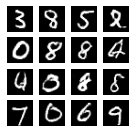

16500: [discriminator loss: 0.540938, acc: 0.742188] [adversarial loss: 1.379205, acc: 0.093750]
16501: [discriminator loss: 0.508961, acc: 0.773438] [adversarial loss: 1.122147, acc: 0.234375]
16502: [discriminator loss: 0.529656, acc: 0.734375] [adversarial loss: 1.019607, acc: 0.343750]
16503: [discriminator loss: 0.594216, acc: 0.710938] [adversarial loss: 1.389812, acc: 0.203125]
16504: [discriminator loss: 0.537664, acc: 0.703125] [adversarial loss: 1.035538, acc: 0.453125]
16505: [discriminator loss: 0.565537, acc: 0.679688] [adversarial loss: 1.672581, acc: 0.156250]
16506: [discriminator loss: 0.563645, acc: 0.656250] [adversarial loss: 0.868002, acc: 0.453125]
16507: [discriminator loss: 0.537237, acc: 0.710938] [adversarial loss: 1.301586, acc: 0.156250]
16508: [discriminator loss: 0.575643, acc: 0.695312] [adversarial loss: 1.330874, acc: 0.343750]
16509: [discriminator loss: 0.546661, acc: 0.750000] [adversarial loss: 1.027308, acc: 0.281250]
16510: [discriminator loss: 0.

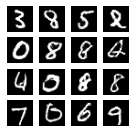

17000: [discriminator loss: 0.545914, acc: 0.710938] [adversarial loss: 1.685329, acc: 0.140625]
17001: [discriminator loss: 0.640254, acc: 0.664062] [adversarial loss: 1.149697, acc: 0.312500]
17002: [discriminator loss: 0.532200, acc: 0.710938] [adversarial loss: 1.428013, acc: 0.109375]
17003: [discriminator loss: 0.612260, acc: 0.687500] [adversarial loss: 1.128215, acc: 0.234375]
17004: [discriminator loss: 0.515608, acc: 0.710938] [adversarial loss: 1.308412, acc: 0.156250]
17005: [discriminator loss: 0.594827, acc: 0.687500] [adversarial loss: 1.146439, acc: 0.281250]
17006: [discriminator loss: 0.534793, acc: 0.742188] [adversarial loss: 1.491815, acc: 0.156250]
17007: [discriminator loss: 0.567586, acc: 0.710938] [adversarial loss: 0.947871, acc: 0.484375]
17008: [discriminator loss: 0.619424, acc: 0.656250] [adversarial loss: 1.326764, acc: 0.265625]
17009: [discriminator loss: 0.569227, acc: 0.703125] [adversarial loss: 0.920149, acc: 0.453125]
17010: [discriminator loss: 0.

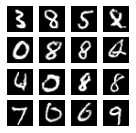

17500: [discriminator loss: 0.572070, acc: 0.648438] [adversarial loss: 1.534736, acc: 0.156250]
17501: [discriminator loss: 0.593348, acc: 0.625000] [adversarial loss: 0.935327, acc: 0.468750]
17502: [discriminator loss: 0.540827, acc: 0.726562] [adversarial loss: 1.398255, acc: 0.140625]
17503: [discriminator loss: 0.576368, acc: 0.695312] [adversarial loss: 1.153944, acc: 0.265625]
17504: [discriminator loss: 0.500810, acc: 0.710938] [adversarial loss: 1.172921, acc: 0.234375]
17505: [discriminator loss: 0.586762, acc: 0.695312] [adversarial loss: 1.014358, acc: 0.359375]
17506: [discriminator loss: 0.523161, acc: 0.710938] [adversarial loss: 1.283001, acc: 0.171875]
17507: [discriminator loss: 0.541118, acc: 0.757812] [adversarial loss: 1.246650, acc: 0.171875]
17508: [discriminator loss: 0.489029, acc: 0.789062] [adversarial loss: 1.513723, acc: 0.125000]
17509: [discriminator loss: 0.468684, acc: 0.781250] [adversarial loss: 1.078419, acc: 0.234375]
17510: [discriminator loss: 0.

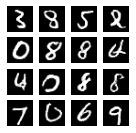

18000: [discriminator loss: 0.525087, acc: 0.781250] [adversarial loss: 1.371003, acc: 0.187500]
18001: [discriminator loss: 0.489062, acc: 0.757812] [adversarial loss: 1.034529, acc: 0.343750]
18002: [discriminator loss: 0.559776, acc: 0.679688] [adversarial loss: 1.556868, acc: 0.078125]
18003: [discriminator loss: 0.556308, acc: 0.718750] [adversarial loss: 0.996401, acc: 0.343750]
18004: [discriminator loss: 0.522611, acc: 0.687500] [adversarial loss: 1.667340, acc: 0.109375]
18005: [discriminator loss: 0.535889, acc: 0.687500] [adversarial loss: 1.092005, acc: 0.250000]
18006: [discriminator loss: 0.473513, acc: 0.757812] [adversarial loss: 1.518185, acc: 0.109375]
18007: [discriminator loss: 0.530074, acc: 0.710938] [adversarial loss: 1.716713, acc: 0.062500]
18008: [discriminator loss: 0.531796, acc: 0.695312] [adversarial loss: 0.958322, acc: 0.375000]
18009: [discriminator loss: 0.564011, acc: 0.695312] [adversarial loss: 1.427691, acc: 0.156250]
18010: [discriminator loss: 0.

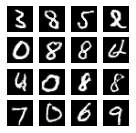

18500: [discriminator loss: 0.605412, acc: 0.632812] [adversarial loss: 0.908499, acc: 0.453125]
18501: [discriminator loss: 0.489545, acc: 0.765625] [adversarial loss: 1.563277, acc: 0.093750]
18502: [discriminator loss: 0.555876, acc: 0.687500] [adversarial loss: 0.859651, acc: 0.453125]
18503: [discriminator loss: 0.583433, acc: 0.703125] [adversarial loss: 1.453586, acc: 0.125000]
18504: [discriminator loss: 0.563439, acc: 0.687500] [adversarial loss: 1.061782, acc: 0.296875]
18505: [discriminator loss: 0.447922, acc: 0.773438] [adversarial loss: 1.126412, acc: 0.343750]
18506: [discriminator loss: 0.491035, acc: 0.773438] [adversarial loss: 1.524514, acc: 0.093750]
18507: [discriminator loss: 0.510736, acc: 0.695312] [adversarial loss: 0.861145, acc: 0.562500]
18508: [discriminator loss: 0.486342, acc: 0.742188] [adversarial loss: 1.322539, acc: 0.250000]
18509: [discriminator loss: 0.536415, acc: 0.742188] [adversarial loss: 1.119015, acc: 0.281250]
18510: [discriminator loss: 0.

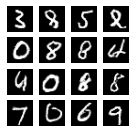

19000: [discriminator loss: 0.457354, acc: 0.781250] [adversarial loss: 0.961993, acc: 0.359375]
19001: [discriminator loss: 0.541317, acc: 0.734375] [adversarial loss: 1.609342, acc: 0.125000]
19002: [discriminator loss: 0.558891, acc: 0.671875] [adversarial loss: 0.981078, acc: 0.437500]
19003: [discriminator loss: 0.533109, acc: 0.703125] [adversarial loss: 1.772068, acc: 0.078125]
19004: [discriminator loss: 0.573602, acc: 0.664062] [adversarial loss: 0.868540, acc: 0.484375]
19005: [discriminator loss: 0.554141, acc: 0.742188] [adversarial loss: 1.526978, acc: 0.171875]
19006: [discriminator loss: 0.521255, acc: 0.742188] [adversarial loss: 1.124763, acc: 0.312500]
19007: [discriminator loss: 0.520684, acc: 0.703125] [adversarial loss: 1.441213, acc: 0.203125]
19008: [discriminator loss: 0.627512, acc: 0.640625] [adversarial loss: 1.262291, acc: 0.234375]
19009: [discriminator loss: 0.468181, acc: 0.789062] [adversarial loss: 1.354629, acc: 0.203125]
19010: [discriminator loss: 0.

19500: [discriminator loss: 0.641426, acc: 0.671875] [adversarial loss: 1.017063, acc: 0.375000]
19501: [discriminator loss: 0.505227, acc: 0.703125] [adversarial loss: 1.348228, acc: 0.171875]
19502: [discriminator loss: 0.529856, acc: 0.742188] [adversarial loss: 0.997117, acc: 0.312500]
19503: [discriminator loss: 0.568860, acc: 0.687500] [adversarial loss: 1.718372, acc: 0.062500]
19504: [discriminator loss: 0.481191, acc: 0.757812] [adversarial loss: 1.035177, acc: 0.328125]
19505: [discriminator loss: 0.565322, acc: 0.703125] [adversarial loss: 1.362464, acc: 0.203125]
19506: [discriminator loss: 0.485996, acc: 0.773438] [adversarial loss: 0.968656, acc: 0.359375]
19507: [discriminator loss: 0.584431, acc: 0.726562] [adversarial loss: 1.484034, acc: 0.171875]
19508: [discriminator loss: 0.539463, acc: 0.703125] [adversarial loss: 0.993942, acc: 0.296875]
19509: [discriminator loss: 0.580831, acc: 0.687500] [adversarial loss: 1.891947, acc: 0.031250]
19510: [discriminator loss: 0.

20000: [discriminator loss: 0.572176, acc: 0.656250] [adversarial loss: 1.239150, acc: 0.218750]
20001: [discriminator loss: 0.526074, acc: 0.734375] [adversarial loss: 1.329709, acc: 0.156250]
20002: [discriminator loss: 0.525889, acc: 0.687500] [adversarial loss: 0.893050, acc: 0.421875]
20003: [discriminator loss: 0.571722, acc: 0.718750] [adversarial loss: 1.620366, acc: 0.109375]
20004: [discriminator loss: 0.515796, acc: 0.742188] [adversarial loss: 0.930218, acc: 0.375000]
20005: [discriminator loss: 0.576099, acc: 0.703125] [adversarial loss: 1.673461, acc: 0.093750]
20006: [discriminator loss: 0.549595, acc: 0.718750] [adversarial loss: 0.830367, acc: 0.453125]
20007: [discriminator loss: 0.508607, acc: 0.750000] [adversarial loss: 1.495019, acc: 0.203125]
20008: [discriminator loss: 0.546380, acc: 0.726562] [adversarial loss: 0.918917, acc: 0.437500]
20009: [discriminator loss: 0.549368, acc: 0.718750] [adversarial loss: 1.259776, acc: 0.140625]
20010: [discriminator loss: 0.

20500: [discriminator loss: 0.500317, acc: 0.734375] [adversarial loss: 1.025753, acc: 0.390625]
20501: [discriminator loss: 0.521933, acc: 0.734375] [adversarial loss: 1.577558, acc: 0.187500]
20502: [discriminator loss: 0.579671, acc: 0.695312] [adversarial loss: 0.947806, acc: 0.421875]
20503: [discriminator loss: 0.546493, acc: 0.695312] [adversarial loss: 1.216591, acc: 0.250000]
20504: [discriminator loss: 0.500368, acc: 0.718750] [adversarial loss: 1.109780, acc: 0.265625]
20505: [discriminator loss: 0.474257, acc: 0.750000] [adversarial loss: 1.252898, acc: 0.250000]
20506: [discriminator loss: 0.531151, acc: 0.718750] [adversarial loss: 0.832055, acc: 0.531250]
20507: [discriminator loss: 0.555245, acc: 0.718750] [adversarial loss: 1.583068, acc: 0.093750]
20508: [discriminator loss: 0.533956, acc: 0.695312] [adversarial loss: 0.910490, acc: 0.437500]
20509: [discriminator loss: 0.463006, acc: 0.781250] [adversarial loss: 1.406167, acc: 0.203125]
20510: [discriminator loss: 0.

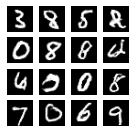

21000: [discriminator loss: 0.541391, acc: 0.695312] [adversarial loss: 0.784898, acc: 0.562500]
21001: [discriminator loss: 0.547240, acc: 0.750000] [adversarial loss: 1.311663, acc: 0.312500]
21002: [discriminator loss: 0.551314, acc: 0.671875] [adversarial loss: 1.058984, acc: 0.343750]
21003: [discriminator loss: 0.531481, acc: 0.742188] [adversarial loss: 1.104884, acc: 0.312500]
21004: [discriminator loss: 0.505434, acc: 0.742188] [adversarial loss: 1.079128, acc: 0.359375]
21005: [discriminator loss: 0.472298, acc: 0.742188] [adversarial loss: 1.778626, acc: 0.109375]
21006: [discriminator loss: 0.477577, acc: 0.757812] [adversarial loss: 1.001255, acc: 0.312500]
21007: [discriminator loss: 0.522149, acc: 0.742188] [adversarial loss: 1.211037, acc: 0.218750]
21008: [discriminator loss: 0.458198, acc: 0.781250] [adversarial loss: 0.912108, acc: 0.406250]
21009: [discriminator loss: 0.485459, acc: 0.781250] [adversarial loss: 1.490850, acc: 0.140625]
21010: [discriminator loss: 0.

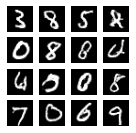

21500: [discriminator loss: 0.496545, acc: 0.734375] [adversarial loss: 1.534597, acc: 0.109375]
21501: [discriminator loss: 0.550412, acc: 0.710938] [adversarial loss: 0.898321, acc: 0.453125]
21502: [discriminator loss: 0.583095, acc: 0.695312] [adversarial loss: 1.614611, acc: 0.078125]
21503: [discriminator loss: 0.540702, acc: 0.703125] [adversarial loss: 0.997688, acc: 0.375000]
21504: [discriminator loss: 0.535056, acc: 0.710938] [adversarial loss: 1.527197, acc: 0.109375]
21505: [discriminator loss: 0.603559, acc: 0.625000] [adversarial loss: 0.985841, acc: 0.421875]
21506: [discriminator loss: 0.631401, acc: 0.640625] [adversarial loss: 1.248549, acc: 0.203125]
21507: [discriminator loss: 0.510362, acc: 0.710938] [adversarial loss: 1.079414, acc: 0.343750]
21508: [discriminator loss: 0.500788, acc: 0.710938] [adversarial loss: 1.409136, acc: 0.187500]
21509: [discriminator loss: 0.482164, acc: 0.773438] [adversarial loss: 0.993656, acc: 0.328125]
21510: [discriminator loss: 0.

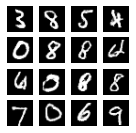

22000: [discriminator loss: 0.545488, acc: 0.703125] [adversarial loss: 1.301223, acc: 0.187500]
22001: [discriminator loss: 0.569843, acc: 0.632812] [adversarial loss: 1.068051, acc: 0.343750]
22002: [discriminator loss: 0.503450, acc: 0.789062] [adversarial loss: 1.752211, acc: 0.109375]
22003: [discriminator loss: 0.538910, acc: 0.742188] [adversarial loss: 0.821316, acc: 0.453125]
22004: [discriminator loss: 0.572186, acc: 0.695312] [adversarial loss: 1.341037, acc: 0.265625]
22005: [discriminator loss: 0.465598, acc: 0.781250] [adversarial loss: 1.106070, acc: 0.343750]
22006: [discriminator loss: 0.462454, acc: 0.781250] [adversarial loss: 1.502135, acc: 0.156250]
22007: [discriminator loss: 0.506902, acc: 0.757812] [adversarial loss: 0.971675, acc: 0.468750]
22008: [discriminator loss: 0.418012, acc: 0.859375] [adversarial loss: 1.520901, acc: 0.265625]
22009: [discriminator loss: 0.552974, acc: 0.664062] [adversarial loss: 0.887447, acc: 0.468750]
22010: [discriminator loss: 0.

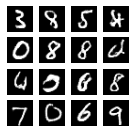

22500: [discriminator loss: 0.492963, acc: 0.789062] [adversarial loss: 1.726642, acc: 0.109375]
22501: [discriminator loss: 0.524400, acc: 0.718750] [adversarial loss: 0.781539, acc: 0.500000]
22502: [discriminator loss: 0.628957, acc: 0.648438] [adversarial loss: 1.569085, acc: 0.187500]
22503: [discriminator loss: 0.589993, acc: 0.648438] [adversarial loss: 1.163199, acc: 0.281250]
22504: [discriminator loss: 0.552959, acc: 0.687500] [adversarial loss: 1.319014, acc: 0.218750]
22505: [discriminator loss: 0.552284, acc: 0.734375] [adversarial loss: 1.111913, acc: 0.250000]
22506: [discriminator loss: 0.552247, acc: 0.734375] [adversarial loss: 1.506885, acc: 0.140625]
22507: [discriminator loss: 0.544495, acc: 0.718750] [adversarial loss: 1.122467, acc: 0.296875]
22508: [discriminator loss: 0.539988, acc: 0.734375] [adversarial loss: 1.588735, acc: 0.140625]
22509: [discriminator loss: 0.593245, acc: 0.695312] [adversarial loss: 0.857039, acc: 0.531250]
22510: [discriminator loss: 0.

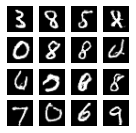

23000: [discriminator loss: 0.524150, acc: 0.718750] [adversarial loss: 1.503704, acc: 0.140625]
23001: [discriminator loss: 0.575042, acc: 0.687500] [adversarial loss: 1.091372, acc: 0.406250]
23002: [discriminator loss: 0.506400, acc: 0.718750] [adversarial loss: 1.831230, acc: 0.109375]
23003: [discriminator loss: 0.599342, acc: 0.656250] [adversarial loss: 1.113269, acc: 0.296875]
23004: [discriminator loss: 0.529670, acc: 0.703125] [adversarial loss: 1.400358, acc: 0.171875]
23005: [discriminator loss: 0.534844, acc: 0.703125] [adversarial loss: 1.065197, acc: 0.312500]
23006: [discriminator loss: 0.654261, acc: 0.671875] [adversarial loss: 1.746393, acc: 0.093750]
23007: [discriminator loss: 0.460317, acc: 0.773438] [adversarial loss: 1.007239, acc: 0.406250]
23008: [discriminator loss: 0.549373, acc: 0.726562] [adversarial loss: 1.609801, acc: 0.171875]
23009: [discriminator loss: 0.578708, acc: 0.656250] [adversarial loss: 0.938785, acc: 0.375000]
23010: [discriminator loss: 0.

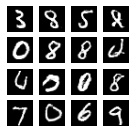

23500: [discriminator loss: 0.528626, acc: 0.718750] [adversarial loss: 1.151914, acc: 0.328125]
23501: [discriminator loss: 0.533671, acc: 0.726562] [adversarial loss: 1.125564, acc: 0.328125]
23502: [discriminator loss: 0.519802, acc: 0.726562] [adversarial loss: 1.132028, acc: 0.296875]
23503: [discriminator loss: 0.513743, acc: 0.734375] [adversarial loss: 1.399321, acc: 0.187500]
23504: [discriminator loss: 0.488854, acc: 0.710938] [adversarial loss: 1.208804, acc: 0.218750]
23505: [discriminator loss: 0.566912, acc: 0.710938] [adversarial loss: 1.422911, acc: 0.187500]
23506: [discriminator loss: 0.526556, acc: 0.703125] [adversarial loss: 0.979125, acc: 0.390625]
23507: [discriminator loss: 0.577484, acc: 0.765625] [adversarial loss: 1.499626, acc: 0.125000]
23508: [discriminator loss: 0.555030, acc: 0.726562] [adversarial loss: 0.906917, acc: 0.421875]
23509: [discriminator loss: 0.476085, acc: 0.796875] [adversarial loss: 1.540509, acc: 0.187500]
23510: [discriminator loss: 0.

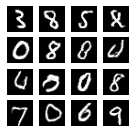

24000: [discriminator loss: 0.501946, acc: 0.718750] [adversarial loss: 1.127276, acc: 0.218750]
24001: [discriminator loss: 0.521460, acc: 0.734375] [adversarial loss: 1.894343, acc: 0.062500]
24002: [discriminator loss: 0.594482, acc: 0.671875] [adversarial loss: 1.292543, acc: 0.218750]
24003: [discriminator loss: 0.550166, acc: 0.757812] [adversarial loss: 1.194418, acc: 0.343750]
24004: [discriminator loss: 0.513786, acc: 0.710938] [adversarial loss: 1.663295, acc: 0.093750]
24005: [discriminator loss: 0.585062, acc: 0.687500] [adversarial loss: 0.971475, acc: 0.390625]
24006: [discriminator loss: 0.570613, acc: 0.726562] [adversarial loss: 1.728292, acc: 0.140625]
24007: [discriminator loss: 0.554960, acc: 0.679688] [adversarial loss: 0.765050, acc: 0.578125]
24008: [discriminator loss: 0.543360, acc: 0.703125] [adversarial loss: 1.220966, acc: 0.265625]
24009: [discriminator loss: 0.534607, acc: 0.718750] [adversarial loss: 1.162054, acc: 0.359375]
24010: [discriminator loss: 0.

24500: [discriminator loss: 0.500999, acc: 0.781250] [adversarial loss: 1.367394, acc: 0.218750]
24501: [discriminator loss: 0.601562, acc: 0.640625] [adversarial loss: 1.268048, acc: 0.281250]
24502: [discriminator loss: 0.546504, acc: 0.765625] [adversarial loss: 1.309785, acc: 0.156250]
24503: [discriminator loss: 0.555897, acc: 0.726562] [adversarial loss: 1.155858, acc: 0.296875]
24504: [discriminator loss: 0.515445, acc: 0.765625] [adversarial loss: 1.359699, acc: 0.218750]
24505: [discriminator loss: 0.532998, acc: 0.742188] [adversarial loss: 1.140112, acc: 0.234375]
24506: [discriminator loss: 0.486828, acc: 0.726562] [adversarial loss: 1.229375, acc: 0.171875]
24507: [discriminator loss: 0.503209, acc: 0.734375] [adversarial loss: 1.304239, acc: 0.171875]
24508: [discriminator loss: 0.455716, acc: 0.789062] [adversarial loss: 1.065404, acc: 0.328125]
24509: [discriminator loss: 0.478434, acc: 0.750000] [adversarial loss: 1.336191, acc: 0.218750]
24510: [discriminator loss: 0.

25000: [discriminator loss: 0.565348, acc: 0.695312] [adversarial loss: 0.895442, acc: 0.468750]
25001: [discriminator loss: 0.610668, acc: 0.656250] [adversarial loss: 1.976964, acc: 0.093750]
25002: [discriminator loss: 0.590274, acc: 0.679688] [adversarial loss: 0.959165, acc: 0.375000]
25003: [discriminator loss: 0.576931, acc: 0.710938] [adversarial loss: 1.919600, acc: 0.078125]
25004: [discriminator loss: 0.530768, acc: 0.718750] [adversarial loss: 1.165592, acc: 0.328125]
25005: [discriminator loss: 0.577789, acc: 0.695312] [adversarial loss: 1.534929, acc: 0.140625]
25006: [discriminator loss: 0.529001, acc: 0.679688] [adversarial loss: 1.348996, acc: 0.218750]
25007: [discriminator loss: 0.550981, acc: 0.679688] [adversarial loss: 1.380532, acc: 0.187500]
25008: [discriminator loss: 0.477114, acc: 0.789062] [adversarial loss: 1.258659, acc: 0.281250]
25009: [discriminator loss: 0.526176, acc: 0.703125] [adversarial loss: 1.092209, acc: 0.359375]
25010: [discriminator loss: 0.

25500: [discriminator loss: 0.563112, acc: 0.718750] [adversarial loss: 0.861108, acc: 0.500000]
25501: [discriminator loss: 0.575837, acc: 0.703125] [adversarial loss: 1.433228, acc: 0.171875]
25502: [discriminator loss: 0.499454, acc: 0.734375] [adversarial loss: 1.277442, acc: 0.281250]
25503: [discriminator loss: 0.444384, acc: 0.796875] [adversarial loss: 1.033999, acc: 0.359375]
25504: [discriminator loss: 0.494950, acc: 0.750000] [adversarial loss: 1.355745, acc: 0.328125]
25505: [discriminator loss: 0.573413, acc: 0.703125] [adversarial loss: 1.356987, acc: 0.125000]
25506: [discriminator loss: 0.499746, acc: 0.765625] [adversarial loss: 1.102993, acc: 0.296875]
25507: [discriminator loss: 0.518970, acc: 0.742188] [adversarial loss: 1.493527, acc: 0.171875]
25508: [discriminator loss: 0.442762, acc: 0.750000] [adversarial loss: 0.897494, acc: 0.500000]
25509: [discriminator loss: 0.615032, acc: 0.695312] [adversarial loss: 1.519474, acc: 0.109375]
25510: [discriminator loss: 0.

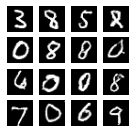

26000: [discriminator loss: 0.508388, acc: 0.710938] [adversarial loss: 1.759438, acc: 0.218750]
26001: [discriminator loss: 0.557939, acc: 0.742188] [adversarial loss: 1.393688, acc: 0.171875]
26002: [discriminator loss: 0.475418, acc: 0.734375] [adversarial loss: 1.625460, acc: 0.125000]
26003: [discriminator loss: 0.568921, acc: 0.664062] [adversarial loss: 0.935401, acc: 0.421875]
26004: [discriminator loss: 0.505006, acc: 0.734375] [adversarial loss: 1.859296, acc: 0.046875]
26005: [discriminator loss: 0.453163, acc: 0.773438] [adversarial loss: 1.188498, acc: 0.375000]
26006: [discriminator loss: 0.574064, acc: 0.718750] [adversarial loss: 1.935575, acc: 0.109375]
26007: [discriminator loss: 0.545417, acc: 0.718750] [adversarial loss: 0.884746, acc: 0.453125]
26008: [discriminator loss: 0.513605, acc: 0.789062] [adversarial loss: 1.619686, acc: 0.187500]
26009: [discriminator loss: 0.598224, acc: 0.695312] [adversarial loss: 0.875488, acc: 0.421875]
26010: [discriminator loss: 0.

26500: [discriminator loss: 0.569073, acc: 0.734375] [adversarial loss: 1.628825, acc: 0.093750]
26501: [discriminator loss: 0.485700, acc: 0.765625] [adversarial loss: 1.503844, acc: 0.109375]
26502: [discriminator loss: 0.533167, acc: 0.765625] [adversarial loss: 1.647717, acc: 0.156250]
26503: [discriminator loss: 0.525348, acc: 0.703125] [adversarial loss: 1.502127, acc: 0.250000]
26504: [discriminator loss: 0.525298, acc: 0.726562] [adversarial loss: 1.149688, acc: 0.343750]
26505: [discriminator loss: 0.535903, acc: 0.718750] [adversarial loss: 1.507322, acc: 0.140625]
26506: [discriminator loss: 0.486706, acc: 0.757812] [adversarial loss: 1.362146, acc: 0.218750]
26507: [discriminator loss: 0.495570, acc: 0.710938] [adversarial loss: 1.062828, acc: 0.375000]
26508: [discriminator loss: 0.515563, acc: 0.726562] [adversarial loss: 1.734344, acc: 0.156250]
26509: [discriminator loss: 0.456160, acc: 0.796875] [adversarial loss: 1.498297, acc: 0.265625]
26510: [discriminator loss: 0.

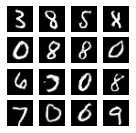

27000: [discriminator loss: 0.420260, acc: 0.812500] [adversarial loss: 1.138228, acc: 0.343750]
27001: [discriminator loss: 0.457273, acc: 0.796875] [adversarial loss: 0.709896, acc: 0.609375]
27002: [discriminator loss: 0.438882, acc: 0.796875] [adversarial loss: 1.536811, acc: 0.234375]
27003: [discriminator loss: 0.493216, acc: 0.750000] [adversarial loss: 0.569868, acc: 0.718750]
27004: [discriminator loss: 0.625059, acc: 0.710938] [adversarial loss: 2.075130, acc: 0.093750]
27005: [discriminator loss: 0.625212, acc: 0.679688] [adversarial loss: 0.961672, acc: 0.406250]
27006: [discriminator loss: 0.493824, acc: 0.757812] [adversarial loss: 1.453238, acc: 0.187500]
27007: [discriminator loss: 0.436009, acc: 0.773438] [adversarial loss: 1.178583, acc: 0.312500]
27008: [discriminator loss: 0.489183, acc: 0.757812] [adversarial loss: 1.611836, acc: 0.218750]
27009: [discriminator loss: 0.361524, acc: 0.843750] [adversarial loss: 1.120440, acc: 0.328125]
27010: [discriminator loss: 0.

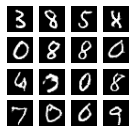

27500: [discriminator loss: 0.441935, acc: 0.765625] [adversarial loss: 1.851716, acc: 0.171875]
27501: [discriminator loss: 0.450334, acc: 0.789062] [adversarial loss: 1.479028, acc: 0.218750]
27502: [discriminator loss: 0.495194, acc: 0.781250] [adversarial loss: 1.767217, acc: 0.218750]
27503: [discriminator loss: 0.389692, acc: 0.851562] [adversarial loss: 1.893355, acc: 0.093750]
27504: [discriminator loss: 0.419443, acc: 0.812500] [adversarial loss: 1.583964, acc: 0.250000]
27505: [discriminator loss: 0.429894, acc: 0.789062] [adversarial loss: 1.766083, acc: 0.156250]
27506: [discriminator loss: 0.463744, acc: 0.796875] [adversarial loss: 2.087514, acc: 0.078125]
27507: [discriminator loss: 0.452347, acc: 0.789062] [adversarial loss: 1.331787, acc: 0.328125]
27508: [discriminator loss: 0.440457, acc: 0.750000] [adversarial loss: 1.927564, acc: 0.109375]
27509: [discriminator loss: 0.385672, acc: 0.804688] [adversarial loss: 1.685919, acc: 0.250000]
27510: [discriminator loss: 0.

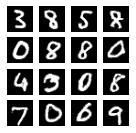

28000: [discriminator loss: 0.415145, acc: 0.796875] [adversarial loss: 2.169792, acc: 0.093750]
28001: [discriminator loss: 0.406113, acc: 0.812500] [adversarial loss: 3.032044, acc: 0.031250]
28002: [discriminator loss: 0.369543, acc: 0.820312] [adversarial loss: 2.634498, acc: 0.078125]
28003: [discriminator loss: 0.366898, acc: 0.820312] [adversarial loss: 2.289722, acc: 0.093750]
28004: [discriminator loss: 0.376508, acc: 0.796875] [adversarial loss: 2.837028, acc: 0.015625]
28005: [discriminator loss: 0.295387, acc: 0.875000] [adversarial loss: 2.206791, acc: 0.078125]
28006: [discriminator loss: 0.277776, acc: 0.890625] [adversarial loss: 3.443761, acc: 0.046875]
28007: [discriminator loss: 0.320496, acc: 0.851562] [adversarial loss: 2.060328, acc: 0.187500]
28008: [discriminator loss: 0.317719, acc: 0.843750] [adversarial loss: 2.687528, acc: 0.046875]
28009: [discriminator loss: 0.307149, acc: 0.851562] [adversarial loss: 1.559251, acc: 0.234375]
28010: [discriminator loss: 0.

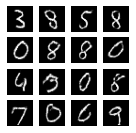

28500: [discriminator loss: 0.108920, acc: 0.968750] [adversarial loss: 3.459847, acc: 0.015625]
28501: [discriminator loss: 0.166711, acc: 0.921875] [adversarial loss: 3.190049, acc: 0.015625]
28502: [discriminator loss: 0.154832, acc: 0.937500] [adversarial loss: 4.049858, acc: 0.000000]
28503: [discriminator loss: 0.177729, acc: 0.929688] [adversarial loss: 3.351474, acc: 0.000000]
28504: [discriminator loss: 0.144744, acc: 0.929688] [adversarial loss: 3.305914, acc: 0.031250]
28505: [discriminator loss: 0.146839, acc: 0.945312] [adversarial loss: 3.240719, acc: 0.015625]
28506: [discriminator loss: 0.171419, acc: 0.945312] [adversarial loss: 4.595141, acc: 0.000000]
28507: [discriminator loss: 0.211853, acc: 0.921875] [adversarial loss: 3.437712, acc: 0.000000]
28508: [discriminator loss: 0.253193, acc: 0.890625] [adversarial loss: 4.592945, acc: 0.015625]
28509: [discriminator loss: 0.169724, acc: 0.937500] [adversarial loss: 3.742850, acc: 0.015625]
28510: [discriminator loss: 0.

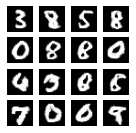

29000: [discriminator loss: 0.173144, acc: 0.960938] [adversarial loss: 8.319741, acc: 0.000000]
29001: [discriminator loss: 0.222456, acc: 0.937500] [adversarial loss: 12.669917, acc: 0.000000]
29002: [discriminator loss: 0.247264, acc: 0.937500] [adversarial loss: 9.099814, acc: 0.000000]
29003: [discriminator loss: 0.183500, acc: 0.937500] [adversarial loss: 10.225573, acc: 0.000000]
29004: [discriminator loss: 0.279779, acc: 0.945312] [adversarial loss: 4.638747, acc: 0.046875]
29005: [discriminator loss: 0.396801, acc: 0.835938] [adversarial loss: 12.137615, acc: 0.000000]
29006: [discriminator loss: 0.252822, acc: 0.929688] [adversarial loss: 7.493742, acc: 0.000000]
29007: [discriminator loss: 0.164156, acc: 0.953125] [adversarial loss: 6.059470, acc: 0.000000]
29008: [discriminator loss: 0.348984, acc: 0.875000] [adversarial loss: 3.452542, acc: 0.109375]
29009: [discriminator loss: 0.393727, acc: 0.835938] [adversarial loss: 5.883398, acc: 0.000000]
29010: [discriminator loss:

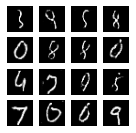

29500: [discriminator loss: 0.072429, acc: 0.976562] [adversarial loss: 4.183464, acc: 0.000000]
29501: [discriminator loss: 0.177710, acc: 0.921875] [adversarial loss: 4.464366, acc: 0.000000]
29502: [discriminator loss: 0.111479, acc: 0.937500] [adversarial loss: 4.364790, acc: 0.015625]
29503: [discriminator loss: 0.097937, acc: 0.953125] [adversarial loss: 5.546420, acc: 0.000000]
29504: [discriminator loss: 0.157548, acc: 0.945312] [adversarial loss: 4.665742, acc: 0.000000]
29505: [discriminator loss: 0.062183, acc: 0.968750] [adversarial loss: 5.117979, acc: 0.000000]
29506: [discriminator loss: 0.063054, acc: 0.984375] [adversarial loss: 5.965707, acc: 0.000000]
29507: [discriminator loss: 0.105629, acc: 0.960938] [adversarial loss: 4.762074, acc: 0.015625]
29508: [discriminator loss: 0.325790, acc: 0.851562] [adversarial loss: 5.669670, acc: 0.000000]
29509: [discriminator loss: 0.205298, acc: 0.921875] [adversarial loss: 1.868050, acc: 0.390625]
29510: [discriminator loss: 0.

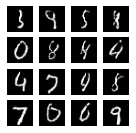

30000: [discriminator loss: 0.348294, acc: 0.867188] [adversarial loss: 0.663160, acc: 0.625000]
30001: [discriminator loss: 0.291003, acc: 0.890625] [adversarial loss: 0.060615, acc: 0.984375]
30002: [discriminator loss: 0.140174, acc: 0.945312] [adversarial loss: 0.116669, acc: 0.953125]
30003: [discriminator loss: 0.208617, acc: 0.914062] [adversarial loss: 0.205385, acc: 0.953125]
30004: [discriminator loss: 0.195203, acc: 0.921875] [adversarial loss: 0.048604, acc: 1.000000]
30005: [discriminator loss: 0.208492, acc: 0.914062] [adversarial loss: 0.377827, acc: 0.828125]
30006: [discriminator loss: 0.333763, acc: 0.859375] [adversarial loss: 0.011749, acc: 1.000000]
30007: [discriminator loss: 0.317308, acc: 0.875000] [adversarial loss: 0.229822, acc: 0.937500]
30008: [discriminator loss: 0.113542, acc: 0.960938] [adversarial loss: 0.073634, acc: 0.968750]
30009: [discriminator loss: 0.157830, acc: 0.937500] [adversarial loss: 0.055883, acc: 0.984375]
30010: [discriminator loss: 0.

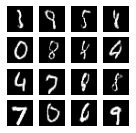

30500: [discriminator loss: 0.252988, acc: 0.906250] [adversarial loss: 1.917472, acc: 0.203125]
30501: [discriminator loss: 0.187584, acc: 0.929688] [adversarial loss: 3.678182, acc: 0.078125]
30502: [discriminator loss: 0.348684, acc: 0.882812] [adversarial loss: 1.382781, acc: 0.406250]
30503: [discriminator loss: 0.271458, acc: 0.859375] [adversarial loss: 1.425787, acc: 0.406250]
30504: [discriminator loss: 0.298961, acc: 0.882812] [adversarial loss: 1.714763, acc: 0.312500]
30505: [discriminator loss: 0.274499, acc: 0.890625] [adversarial loss: 0.450652, acc: 0.828125]
30506: [discriminator loss: 0.328182, acc: 0.843750] [adversarial loss: 4.014956, acc: 0.171875]
30507: [discriminator loss: 0.350909, acc: 0.875000] [adversarial loss: 1.188882, acc: 0.593750]
30508: [discriminator loss: 0.348545, acc: 0.882812] [adversarial loss: 2.819121, acc: 0.187500]
30509: [discriminator loss: 0.319932, acc: 0.890625] [adversarial loss: 1.669944, acc: 0.312500]
30510: [discriminator loss: 0.

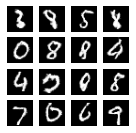

31000: [discriminator loss: 0.296359, acc: 0.875000] [adversarial loss: 1.375232, acc: 0.484375]
31001: [discriminator loss: 0.417915, acc: 0.843750] [adversarial loss: 3.319714, acc: 0.078125]
31002: [discriminator loss: 0.469915, acc: 0.828125] [adversarial loss: 1.089677, acc: 0.500000]
31003: [discriminator loss: 0.357901, acc: 0.835938] [adversarial loss: 3.645572, acc: 0.078125]
31004: [discriminator loss: 0.307400, acc: 0.851562] [adversarial loss: 1.393606, acc: 0.296875]
31005: [discriminator loss: 0.268010, acc: 0.875000] [adversarial loss: 2.893223, acc: 0.031250]
31006: [discriminator loss: 0.293927, acc: 0.859375] [adversarial loss: 1.492532, acc: 0.359375]
31007: [discriminator loss: 0.202993, acc: 0.898438] [adversarial loss: 2.457892, acc: 0.093750]
31008: [discriminator loss: 0.306031, acc: 0.882812] [adversarial loss: 1.993412, acc: 0.140625]
31009: [discriminator loss: 0.213222, acc: 0.914062] [adversarial loss: 1.149000, acc: 0.437500]
31010: [discriminator loss: 0.

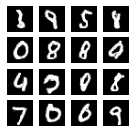

31500: [discriminator loss: 0.286449, acc: 0.875000] [adversarial loss: 3.696790, acc: 0.000000]
31501: [discriminator loss: 0.266773, acc: 0.875000] [adversarial loss: 2.134260, acc: 0.140625]
31502: [discriminator loss: 0.305223, acc: 0.851562] [adversarial loss: 3.892633, acc: 0.046875]
31503: [discriminator loss: 0.445988, acc: 0.859375] [adversarial loss: 2.049563, acc: 0.171875]
31504: [discriminator loss: 0.352725, acc: 0.843750] [adversarial loss: 4.467286, acc: 0.015625]
31505: [discriminator loss: 0.496493, acc: 0.820312] [adversarial loss: 1.247848, acc: 0.375000]
31506: [discriminator loss: 0.241775, acc: 0.906250] [adversarial loss: 2.605792, acc: 0.046875]
31507: [discriminator loss: 0.206772, acc: 0.898438] [adversarial loss: 2.662092, acc: 0.078125]
31508: [discriminator loss: 0.239922, acc: 0.890625] [adversarial loss: 2.069858, acc: 0.125000]
31509: [discriminator loss: 0.222803, acc: 0.906250] [adversarial loss: 2.874090, acc: 0.062500]
31510: [discriminator loss: 0.

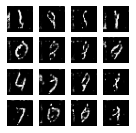

32000: [discriminator loss: 0.137617, acc: 0.953125] [adversarial loss: 5.242102, acc: 0.000000]
32001: [discriminator loss: 0.026487, acc: 0.992188] [adversarial loss: 4.663666, acc: 0.000000]
32002: [discriminator loss: 0.044374, acc: 0.968750] [adversarial loss: 5.476742, acc: 0.000000]
32003: [discriminator loss: 0.074619, acc: 0.968750] [adversarial loss: 6.716800, acc: 0.000000]
32004: [discriminator loss: 0.130655, acc: 0.953125] [adversarial loss: 5.023275, acc: 0.000000]
32005: [discriminator loss: 0.046593, acc: 0.976562] [adversarial loss: 5.309430, acc: 0.000000]
32006: [discriminator loss: 0.036135, acc: 0.984375] [adversarial loss: 4.118155, acc: 0.031250]
32007: [discriminator loss: 0.068903, acc: 0.960938] [adversarial loss: 4.683998, acc: 0.015625]
32008: [discriminator loss: 0.069905, acc: 0.976562] [adversarial loss: 3.258841, acc: 0.078125]
32009: [discriminator loss: 0.149145, acc: 0.906250] [adversarial loss: 7.019467, acc: 0.000000]
32010: [discriminator loss: 0.

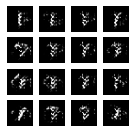

32500: [discriminator loss: 0.001141, acc: 1.000000] [adversarial loss: 2.938843, acc: 0.000000]
32501: [discriminator loss: 0.000472, acc: 1.000000] [adversarial loss: 3.306340, acc: 0.000000]
32502: [discriminator loss: 0.000602, acc: 1.000000] [adversarial loss: 3.363723, acc: 0.000000]
32503: [discriminator loss: 0.000256, acc: 1.000000] [adversarial loss: 3.724955, acc: 0.000000]
32504: [discriminator loss: 0.000948, acc: 1.000000] [adversarial loss: 3.247724, acc: 0.000000]
32505: [discriminator loss: 0.006816, acc: 0.992188] [adversarial loss: 1.081871, acc: 0.343750]
32506: [discriminator loss: 0.017913, acc: 1.000000] [adversarial loss: 11.454533, acc: 0.000000]
32507: [discriminator loss: 0.005386, acc: 1.000000] [adversarial loss: 7.460691, acc: 0.000000]
32508: [discriminator loss: 0.000068, acc: 1.000000] [adversarial loss: 6.997525, acc: 0.000000]
32509: [discriminator loss: 0.000022, acc: 1.000000] [adversarial loss: 6.573346, acc: 0.000000]
32510: [discriminator loss: 0

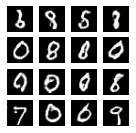

33000: [discriminator loss: 0.233681, acc: 0.906250] [adversarial loss: 3.067381, acc: 0.093750]
33001: [discriminator loss: 0.295122, acc: 0.859375] [adversarial loss: 1.084107, acc: 0.437500]
33002: [discriminator loss: 0.206478, acc: 0.921875] [adversarial loss: 2.544484, acc: 0.125000]
33003: [discriminator loss: 0.193574, acc: 0.921875] [adversarial loss: 1.873415, acc: 0.343750]
33004: [discriminator loss: 0.204798, acc: 0.921875] [adversarial loss: 2.003778, acc: 0.203125]
33005: [discriminator loss: 0.306132, acc: 0.843750] [adversarial loss: 2.236801, acc: 0.312500]
33006: [discriminator loss: 0.216891, acc: 0.898438] [adversarial loss: 1.517932, acc: 0.375000]
33007: [discriminator loss: 0.174212, acc: 0.914062] [adversarial loss: 1.766778, acc: 0.390625]
33008: [discriminator loss: 0.176015, acc: 0.906250] [adversarial loss: 2.373955, acc: 0.140625]
33009: [discriminator loss: 0.181578, acc: 0.921875] [adversarial loss: 1.449821, acc: 0.421875]
33010: [discriminator loss: 0.

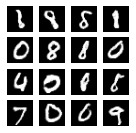

33500: [discriminator loss: 0.355900, acc: 0.859375] [adversarial loss: 1.775684, acc: 0.140625]
33501: [discriminator loss: 0.348636, acc: 0.843750] [adversarial loss: 2.238878, acc: 0.046875]
33502: [discriminator loss: 0.369374, acc: 0.812500] [adversarial loss: 1.332373, acc: 0.312500]
33503: [discriminator loss: 0.361130, acc: 0.828125] [adversarial loss: 2.420846, acc: 0.062500]
33504: [discriminator loss: 0.425804, acc: 0.851562] [adversarial loss: 1.237602, acc: 0.375000]
33505: [discriminator loss: 0.364918, acc: 0.835938] [adversarial loss: 2.690923, acc: 0.046875]
33506: [discriminator loss: 0.337704, acc: 0.843750] [adversarial loss: 1.614581, acc: 0.156250]
33507: [discriminator loss: 0.360868, acc: 0.835938] [adversarial loss: 2.790648, acc: 0.031250]
33508: [discriminator loss: 0.455760, acc: 0.750000] [adversarial loss: 1.643172, acc: 0.250000]
33509: [discriminator loss: 0.535635, acc: 0.734375] [adversarial loss: 1.779156, acc: 0.140625]
33510: [discriminator loss: 0.

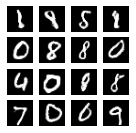

34000: [discriminator loss: 0.462206, acc: 0.765625] [adversarial loss: 1.636599, acc: 0.187500]
34001: [discriminator loss: 0.531621, acc: 0.718750] [adversarial loss: 1.665357, acc: 0.171875]
34002: [discriminator loss: 0.445704, acc: 0.734375] [adversarial loss: 1.321949, acc: 0.296875]
34003: [discriminator loss: 0.476603, acc: 0.742188] [adversarial loss: 1.799629, acc: 0.062500]
34004: [discriminator loss: 0.465442, acc: 0.781250] [adversarial loss: 1.486121, acc: 0.171875]
34005: [discriminator loss: 0.469600, acc: 0.765625] [adversarial loss: 1.720431, acc: 0.140625]
34006: [discriminator loss: 0.500819, acc: 0.765625] [adversarial loss: 1.378944, acc: 0.203125]
34007: [discriminator loss: 0.389709, acc: 0.835938] [adversarial loss: 1.194427, acc: 0.312500]
34008: [discriminator loss: 0.463571, acc: 0.726562] [adversarial loss: 2.133844, acc: 0.062500]
34009: [discriminator loss: 0.481440, acc: 0.781250] [adversarial loss: 1.184597, acc: 0.312500]
34010: [discriminator loss: 0.

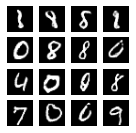

34500: [discriminator loss: 0.515344, acc: 0.710938] [adversarial loss: 1.095158, acc: 0.406250]
34501: [discriminator loss: 0.494008, acc: 0.726562] [adversarial loss: 1.927843, acc: 0.062500]
34502: [discriminator loss: 0.398868, acc: 0.773438] [adversarial loss: 1.345691, acc: 0.296875]
34503: [discriminator loss: 0.447657, acc: 0.765625] [adversarial loss: 1.553359, acc: 0.187500]
34504: [discriminator loss: 0.501676, acc: 0.757812] [adversarial loss: 1.423265, acc: 0.234375]
34505: [discriminator loss: 0.423918, acc: 0.820312] [adversarial loss: 1.364345, acc: 0.250000]
34506: [discriminator loss: 0.429022, acc: 0.773438] [adversarial loss: 1.496610, acc: 0.140625]
34507: [discriminator loss: 0.492341, acc: 0.773438] [adversarial loss: 1.533268, acc: 0.156250]
34508: [discriminator loss: 0.468311, acc: 0.757812] [adversarial loss: 1.335481, acc: 0.296875]
34509: [discriminator loss: 0.498231, acc: 0.773438] [adversarial loss: 1.733521, acc: 0.078125]
34510: [discriminator loss: 0.

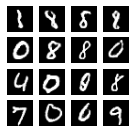

35000: [discriminator loss: 0.490794, acc: 0.750000] [adversarial loss: 1.610858, acc: 0.140625]
35001: [discriminator loss: 0.502400, acc: 0.734375] [adversarial loss: 1.696643, acc: 0.171875]
35002: [discriminator loss: 0.413505, acc: 0.804688] [adversarial loss: 1.269600, acc: 0.281250]
35003: [discriminator loss: 0.484560, acc: 0.781250] [adversarial loss: 1.298848, acc: 0.218750]
35004: [discriminator loss: 0.458033, acc: 0.789062] [adversarial loss: 1.297799, acc: 0.312500]
35005: [discriminator loss: 0.435560, acc: 0.773438] [adversarial loss: 1.472124, acc: 0.140625]
35006: [discriminator loss: 0.513855, acc: 0.765625] [adversarial loss: 1.479525, acc: 0.218750]
35007: [discriminator loss: 0.402575, acc: 0.804688] [adversarial loss: 1.557457, acc: 0.218750]
35008: [discriminator loss: 0.445780, acc: 0.757812] [adversarial loss: 1.257499, acc: 0.203125]
35009: [discriminator loss: 0.584358, acc: 0.679688] [adversarial loss: 1.493691, acc: 0.171875]
35010: [discriminator loss: 0.

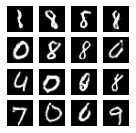

35500: [discriminator loss: 0.500131, acc: 0.718750] [adversarial loss: 1.166212, acc: 0.343750]
35501: [discriminator loss: 0.492125, acc: 0.765625] [adversarial loss: 1.461734, acc: 0.125000]
35502: [discriminator loss: 0.490713, acc: 0.718750] [adversarial loss: 1.120725, acc: 0.312500]
35503: [discriminator loss: 0.444026, acc: 0.773438] [adversarial loss: 1.860797, acc: 0.156250]
35504: [discriminator loss: 0.482600, acc: 0.757812] [adversarial loss: 1.363541, acc: 0.234375]
35505: [discriminator loss: 0.447445, acc: 0.804688] [adversarial loss: 1.748470, acc: 0.140625]
35506: [discriminator loss: 0.467636, acc: 0.781250] [adversarial loss: 1.044930, acc: 0.390625]
35507: [discriminator loss: 0.395708, acc: 0.843750] [adversarial loss: 1.619017, acc: 0.093750]
35508: [discriminator loss: 0.421292, acc: 0.781250] [adversarial loss: 1.229674, acc: 0.359375]
35509: [discriminator loss: 0.455542, acc: 0.765625] [adversarial loss: 1.468712, acc: 0.234375]
35510: [discriminator loss: 0.

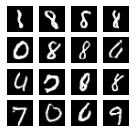

36000: [discriminator loss: 0.525366, acc: 0.710938] [adversarial loss: 1.491642, acc: 0.171875]
36001: [discriminator loss: 0.454519, acc: 0.750000] [adversarial loss: 1.569026, acc: 0.140625]
36002: [discriminator loss: 0.496290, acc: 0.750000] [adversarial loss: 1.583928, acc: 0.109375]
36003: [discriminator loss: 0.522796, acc: 0.742188] [adversarial loss: 1.840582, acc: 0.078125]
36004: [discriminator loss: 0.467982, acc: 0.773438] [adversarial loss: 0.908737, acc: 0.531250]
36005: [discriminator loss: 0.574188, acc: 0.710938] [adversarial loss: 2.408711, acc: 0.031250]
36006: [discriminator loss: 0.635889, acc: 0.671875] [adversarial loss: 0.811026, acc: 0.578125]
36007: [discriminator loss: 0.624651, acc: 0.664062] [adversarial loss: 2.217777, acc: 0.046875]
36008: [discriminator loss: 0.523746, acc: 0.695312] [adversarial loss: 0.999028, acc: 0.312500]
36009: [discriminator loss: 0.600731, acc: 0.679688] [adversarial loss: 1.539033, acc: 0.093750]
36010: [discriminator loss: 0.

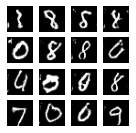

36500: [discriminator loss: 0.369281, acc: 0.828125] [adversarial loss: 0.712887, acc: 0.625000]
36501: [discriminator loss: 0.240917, acc: 0.914062] [adversarial loss: 0.669303, acc: 0.656250]
36502: [discriminator loss: 0.277516, acc: 0.890625] [adversarial loss: 1.108845, acc: 0.390625]
36503: [discriminator loss: 0.340863, acc: 0.867188] [adversarial loss: 0.664707, acc: 0.609375]
36504: [discriminator loss: 0.444672, acc: 0.781250] [adversarial loss: 1.837654, acc: 0.171875]
36505: [discriminator loss: 0.418383, acc: 0.781250] [adversarial loss: 0.965197, acc: 0.437500]
36506: [discriminator loss: 0.566358, acc: 0.734375] [adversarial loss: 2.077665, acc: 0.062500]
36507: [discriminator loss: 0.498252, acc: 0.718750] [adversarial loss: 0.864153, acc: 0.500000]
36508: [discriminator loss: 0.433702, acc: 0.789062] [adversarial loss: 1.269879, acc: 0.250000]
36509: [discriminator loss: 0.445361, acc: 0.773438] [adversarial loss: 1.277879, acc: 0.296875]
36510: [discriminator loss: 0.

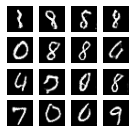

37000: [discriminator loss: 0.297242, acc: 0.906250] [adversarial loss: 2.754970, acc: 0.031250]
37001: [discriminator loss: 0.309604, acc: 0.875000] [adversarial loss: 1.885642, acc: 0.109375]
37002: [discriminator loss: 0.253582, acc: 0.906250] [adversarial loss: 2.424270, acc: 0.078125]
37003: [discriminator loss: 0.378777, acc: 0.781250] [adversarial loss: 1.186650, acc: 0.343750]
37004: [discriminator loss: 0.356738, acc: 0.867188] [adversarial loss: 2.811553, acc: 0.031250]
37005: [discriminator loss: 0.463788, acc: 0.828125] [adversarial loss: 1.267769, acc: 0.312500]
37006: [discriminator loss: 0.325980, acc: 0.867188] [adversarial loss: 1.809150, acc: 0.171875]
37007: [discriminator loss: 0.302397, acc: 0.890625] [adversarial loss: 1.126550, acc: 0.453125]
37008: [discriminator loss: 0.237018, acc: 0.898438] [adversarial loss: 2.490342, acc: 0.031250]
37009: [discriminator loss: 0.297754, acc: 0.875000] [adversarial loss: 1.769020, acc: 0.203125]
37010: [discriminator loss: 0.

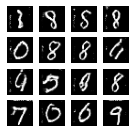

37500: [discriminator loss: 0.090662, acc: 0.976562] [adversarial loss: 0.584711, acc: 0.734375]
37501: [discriminator loss: 0.045509, acc: 0.992188] [adversarial loss: 0.484700, acc: 0.781250]
37502: [discriminator loss: 0.035089, acc: 0.976562] [adversarial loss: 0.175664, acc: 0.921875]
37503: [discriminator loss: 0.023191, acc: 0.992188] [adversarial loss: 0.153640, acc: 0.921875]
37504: [discriminator loss: 0.040826, acc: 0.992188] [adversarial loss: 0.506533, acc: 0.750000]
37505: [discriminator loss: 0.056325, acc: 0.984375] [adversarial loss: 0.869072, acc: 0.546875]
37506: [discriminator loss: 0.025211, acc: 1.000000] [adversarial loss: 0.426760, acc: 0.828125]
37507: [discriminator loss: 0.017753, acc: 1.000000] [adversarial loss: 0.260392, acc: 0.890625]
37508: [discriminator loss: 0.175851, acc: 0.929688] [adversarial loss: 1.633295, acc: 0.375000]
37509: [discriminator loss: 0.207103, acc: 0.898438] [adversarial loss: 0.313688, acc: 0.843750]
37510: [discriminator loss: 0.

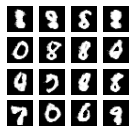

38000: [discriminator loss: 0.162653, acc: 0.953125] [adversarial loss: 10.362791, acc: 0.000000]
38001: [discriminator loss: 0.212645, acc: 0.937500] [adversarial loss: 3.082260, acc: 0.171875]
38002: [discriminator loss: 0.085233, acc: 0.984375] [adversarial loss: 2.155175, acc: 0.359375]
38003: [discriminator loss: 0.173421, acc: 0.937500] [adversarial loss: 0.352783, acc: 0.875000]
38004: [discriminator loss: 0.191229, acc: 0.929688] [adversarial loss: 1.043811, acc: 0.640625]
38005: [discriminator loss: 0.040360, acc: 0.976562] [adversarial loss: 0.272962, acc: 0.890625]
38006: [discriminator loss: 0.059456, acc: 0.992188] [adversarial loss: 0.102425, acc: 0.968750]
38007: [discriminator loss: 0.056337, acc: 0.976562] [adversarial loss: 0.348133, acc: 0.906250]
38008: [discriminator loss: 0.065962, acc: 0.976562] [adversarial loss: 0.220757, acc: 0.875000]
38009: [discriminator loss: 0.061652, acc: 0.968750] [adversarial loss: 0.076139, acc: 0.968750]
38010: [discriminator loss: 0

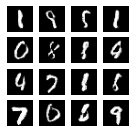

38500: [discriminator loss: 0.084743, acc: 0.984375] [adversarial loss: 0.132785, acc: 0.953125]
38501: [discriminator loss: 0.129775, acc: 0.929688] [adversarial loss: 0.147624, acc: 0.937500]
38502: [discriminator loss: 0.192166, acc: 0.921875] [adversarial loss: 0.143555, acc: 0.921875]
38503: [discriminator loss: 0.070322, acc: 0.968750] [adversarial loss: 0.056600, acc: 1.000000]
38504: [discriminator loss: 0.070785, acc: 0.968750] [adversarial loss: 0.100821, acc: 0.968750]
38505: [discriminator loss: 0.092425, acc: 0.968750] [adversarial loss: 0.149038, acc: 0.937500]
38506: [discriminator loss: 0.137316, acc: 0.937500] [adversarial loss: 0.013222, acc: 1.000000]
38507: [discriminator loss: 0.118022, acc: 0.968750] [adversarial loss: 0.104312, acc: 0.953125]
38508: [discriminator loss: 0.141007, acc: 0.937500] [adversarial loss: 0.004913, acc: 1.000000]
38509: [discriminator loss: 0.164145, acc: 0.921875] [adversarial loss: 0.658806, acc: 0.765625]
38510: [discriminator loss: 0.

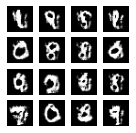

39000: [discriminator loss: 0.039271, acc: 0.984375] [adversarial loss: 0.164185, acc: 0.953125]
39001: [discriminator loss: 0.003677, acc: 1.000000] [adversarial loss: 0.122050, acc: 0.937500]
39002: [discriminator loss: 0.003419, acc: 1.000000] [adversarial loss: 0.016824, acc: 1.000000]
39003: [discriminator loss: 0.114060, acc: 0.984375] [adversarial loss: 0.093271, acc: 0.937500]
39004: [discriminator loss: 0.032693, acc: 0.984375] [adversarial loss: 0.694612, acc: 0.750000]
39005: [discriminator loss: 0.007763, acc: 1.000000] [adversarial loss: 0.056625, acc: 0.984375]
39006: [discriminator loss: 0.073327, acc: 0.976562] [adversarial loss: 0.186429, acc: 0.968750]
39007: [discriminator loss: 0.037108, acc: 0.984375] [adversarial loss: 0.202587, acc: 0.906250]
39008: [discriminator loss: 0.032583, acc: 0.992188] [adversarial loss: 0.237302, acc: 0.906250]
39009: [discriminator loss: 0.022739, acc: 0.984375] [adversarial loss: 0.282846, acc: 0.921875]
39010: [discriminator loss: 0.

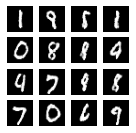

39500: [discriminator loss: 0.260914, acc: 0.906250] [adversarial loss: 4.574230, acc: 0.062500]
39501: [discriminator loss: 0.357094, acc: 0.875000] [adversarial loss: 2.694474, acc: 0.156250]
39502: [discriminator loss: 0.227838, acc: 0.914062] [adversarial loss: 3.133062, acc: 0.140625]
39503: [discriminator loss: 0.273109, acc: 0.898438] [adversarial loss: 1.421088, acc: 0.421875]
39504: [discriminator loss: 0.225317, acc: 0.898438] [adversarial loss: 3.085252, acc: 0.078125]
39505: [discriminator loss: 0.207235, acc: 0.906250] [adversarial loss: 2.179739, acc: 0.328125]
39506: [discriminator loss: 0.203620, acc: 0.914062] [adversarial loss: 2.772777, acc: 0.140625]
39507: [discriminator loss: 0.253756, acc: 0.890625] [adversarial loss: 3.372871, acc: 0.078125]
39508: [discriminator loss: 0.269882, acc: 0.898438] [adversarial loss: 2.417654, acc: 0.218750]
39509: [discriminator loss: 0.261182, acc: 0.882812] [adversarial loss: 4.874992, acc: 0.031250]
39510: [discriminator loss: 0.

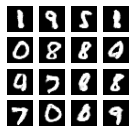

In [8]:
Generator = build_and_train_models()

In [11]:
Image.open('/content/dcgan_mnist/02000.png')

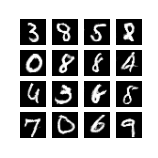

In [13]:
Image.open('/content/dcgan_mnist/09000.png')

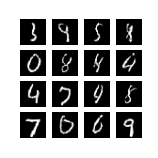

In [14]:
Image.open('/content/dcgan_mnist/30000.png')

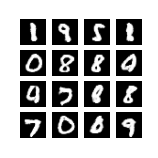

In [15]:
Image.open('/content/dcgan_mnist/40000.png')